
<h1>Predicting Wine Quality with Machine Learning<h1>
<h2>Sara Mancini - 66458A<h2>

## Setup

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, log_loss
from sklearn.base import BaseEstimator, ClassifierMixin

import time
from tqdm import tqdm

Download and load datasets

In [2]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')

print('red:', red.shape)
print('white:', white.shape)

red: (1599, 12)
white: (4898, 12)


## Data Exploration and Preprocessing

Combine datasets into a single dataframe

In [3]:
red['type'] = 0
white['type'] = 1

df = pd.concat([red, white], axis=0).reset_index(drop=True)

df['label'] = (df['quality'] >= 6).astype(int)

print("dataset shape:", df.shape)
print(df[['quality', 'label', 'type']].head())

dataset shape: (6497, 14)
   quality  label  type
0        5      0     0
1        5      0     0
2        5      0     0
3        6      1     0
4        5      0     0


Scale and split dataset

In [4]:
X = df.drop(columns=['quality', 'label'])
y = df['label'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

### Some metrics

Wine quality ratings

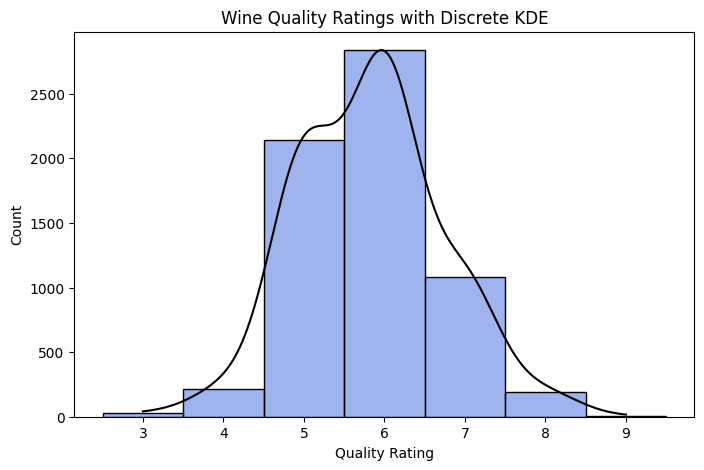

In [7]:
plt.figure(figsize=(8, 5))

sns.histplot(
    data=df,
    x='quality',
    bins=range(df['quality'].min(), df['quality'].max() + 1),
    kde=True,
    discrete=True,
    color='#4169e1',
    kde_kws={'bw_adjust': 2.85},
)

plt.gca().lines[-1].set_color('black')

plt.title('Wine Quality Ratings with Discrete KDE')
plt.xlabel('Quality Rating')
plt.ylabel('Count')

plt.show()

Wine quality by type

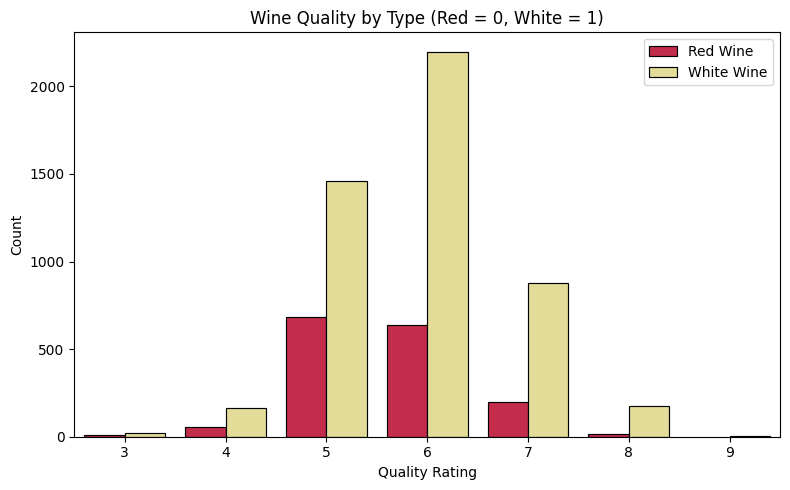

In [9]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data=df, x='quality', hue='type', palette=['crimson', 'khaki'])
for bar in ax.patches:
    bar.set_edgecolor('black')
    bar.set_linewidth(0.85)

plt.title('Wine Quality by Type (Red = 0, White = 1)')
plt.xlabel('Quality Rating')
plt.ylabel('Count')
plt.legend(['Red Wine', 'White Wine'])
plt.tight_layout()
plt.savefig('wine_type_quality.png')
plt.show()

Correlation heatmap

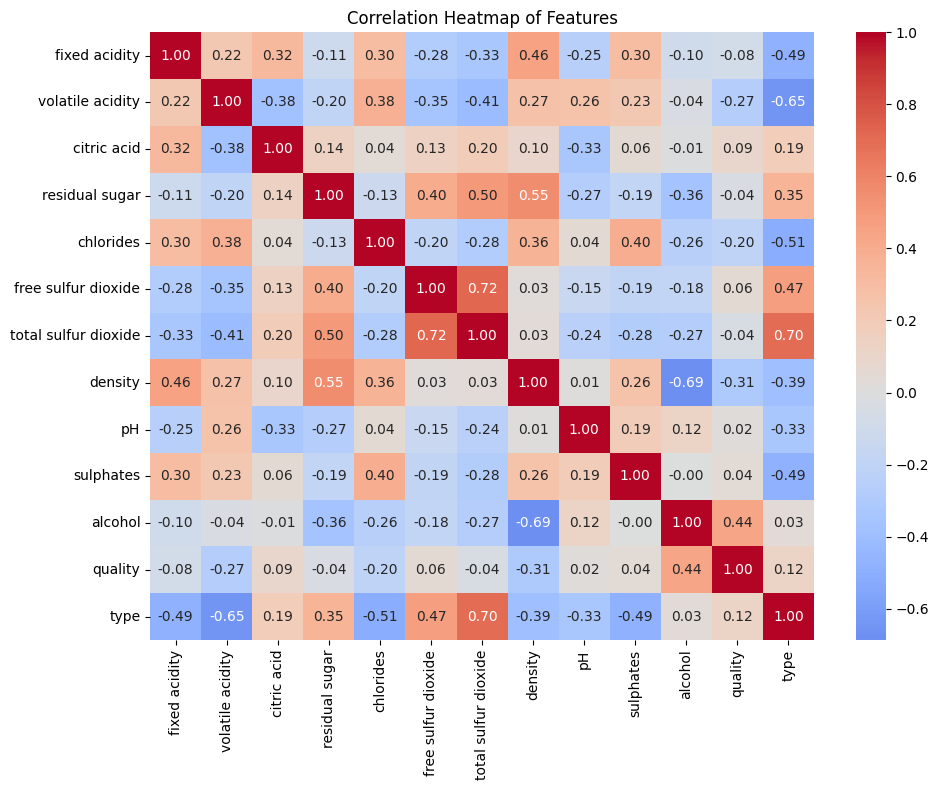

In [7]:
features_only = df.drop(columns=["label"])
corr_matrix = features_only.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()

Some feature distributions before and after scaling

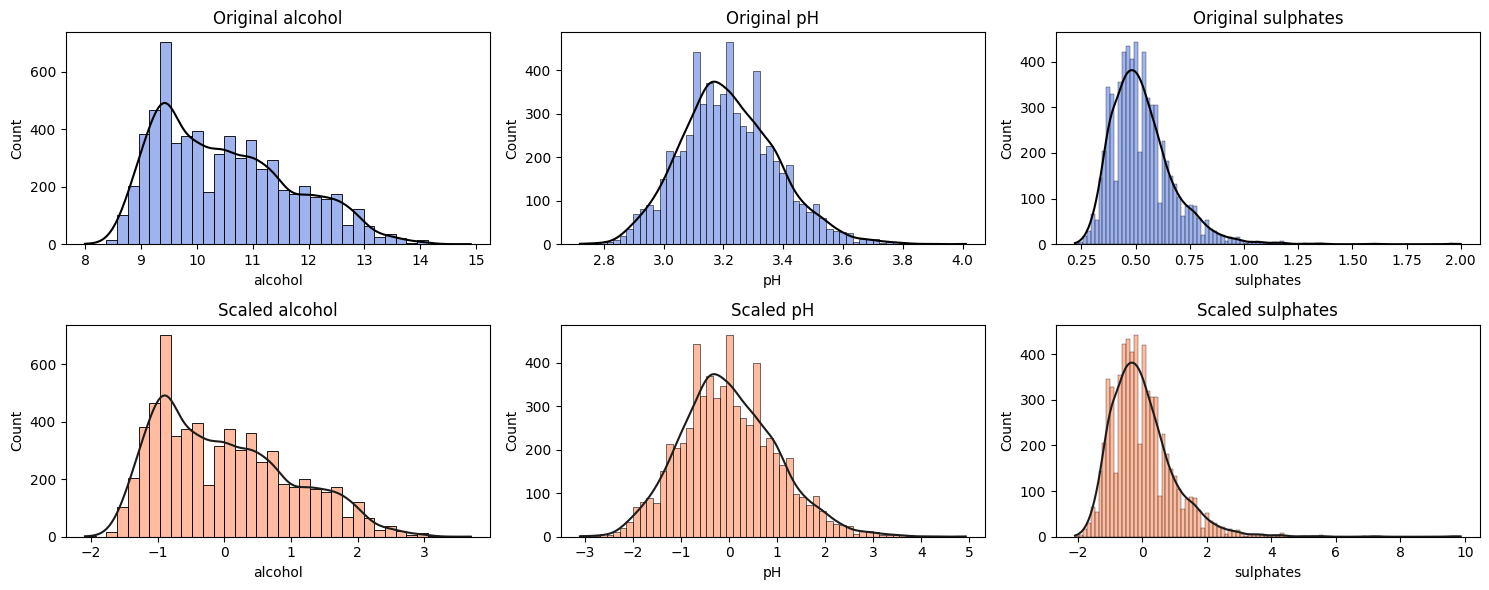

In [10]:
features = ['alcohol', 'pH', 'sulphates']
X_df = df
X_scaled_df = pd.DataFrame(X, columns=df.columns.drop(['quality','label']))

plt.figure(figsize=(15,6))

for i, feature in enumerate(features):
    plt.subplot(2, len(features), i+1)
    ax = sns.histplot(X_df[feature], kde=True, color='#4169e1')
    ax.lines[0].set_color('black')
    plt.title(f'Original {feature}')

    plt.subplot(2, len(features), i+1+len(features))
    ax2 = sns.histplot(X_scaled_df[feature], kde=True, color='#ff7b43')
    ax2.lines[0].set_color('#1c1c1c')
    plt.title(f'Scaled {feature}')

plt.tight_layout()
plt.show()


Label distributions before and after splitting

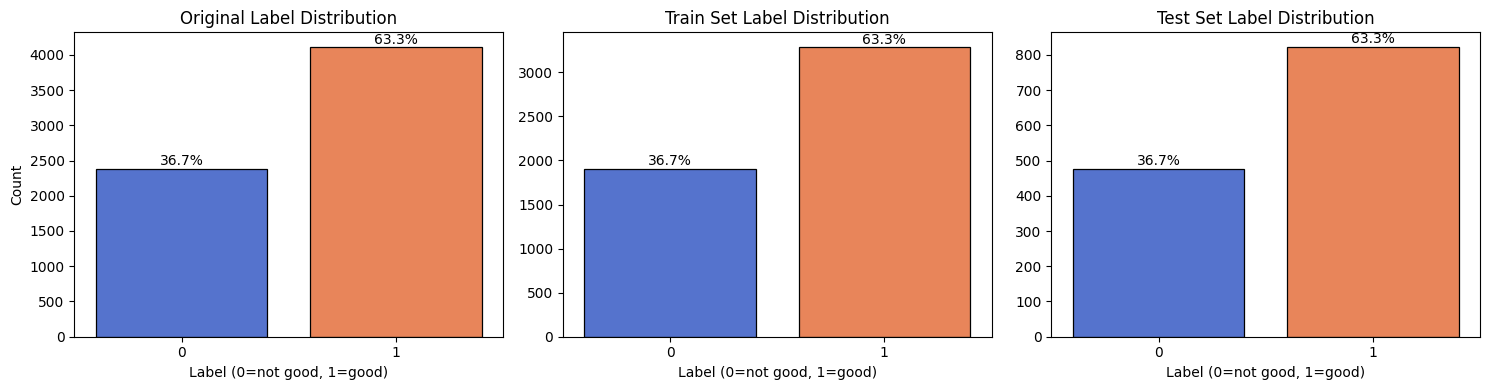

In [11]:
def plot_label_distribution(y_all, y_train, y_test):
    def get_percentages(y_subset):
        unique, counts = np.unique(y_subset, return_counts=True)
        percentages = counts / len(y_subset) * 100
        return dict(zip(unique, percentages))

    def add_labels(ax, y_subset):
        percentages = get_percentages(y_subset)
        for p in ax.patches:
            label = int(p.get_x() + p.get_width() / 2)
            percent = percentages.get(label, 0)
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2,
                    height + 3,
                    f"{percent:.1f}%",
                    ha='center', va='bottom', fontsize=10)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    ax = axs[0]
    sns.countplot(x=y_all, hue=y_all, palette=['#4169e1', '#ff7b43'], legend=False, ax=ax)
    add_labels(ax, y_all)
    ax.set_title('Original Label Distribution')
    ax.set_xlabel('Label (0=not good, 1=good)')
    ax.set_ylabel('Count')
    for bar in ax.patches:
      bar.set_edgecolor('black')
      bar.set_linewidth(0.9)

    ax = axs[1]
    sns.countplot(x=y_train, hue=y_train, palette=['#4169e1', '#ff7b43'], legend=False, ax=ax)
    add_labels(ax, y_train)
    ax.set_title('Train Set Label Distribution')
    ax.set_xlabel('Label (0=not good, 1=good)')
    ax.set_ylabel('')
    for bar in ax.patches:
      bar.set_edgecolor('black')
      bar.set_linewidth(0.9)

    ax = axs[2]
    sns.countplot(x=y_test, hue=y_test, palette=['#4169e1', '#ff7b43'], legend=False, ax=ax)
    add_labels(ax, y_test)
    ax.set_title('Test Set Label Distribution')
    ax.set_xlabel('Label (0=not good, 1=good)')
    ax.set_ylabel('')
    for bar in ax.patches:
      bar.set_edgecolor('black')
      bar.set_linewidth(0.9)

    plt.tight_layout()
    plt.show()

plot_label_distribution(y, y_train, y_test)

## SVM and LR Implementation

### Model definition

Logistic Regression from scratch

In [245]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.1, n_iter=1000, C=1.0):
        self.lr = lr
        self.n_iter = n_iter
        self.C = C
        self.train_losses = []
        self.train_accuracies = []

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        lambda_reg = 1 / self.C

        for _ in range(self.n_iter):
            linear_output = np.dot(X, self.w) + self.b
            prob = self._sigmoid(linear_output)

            grad_w = (np.dot(X.T, (prob - y)) / n_samples) + lambda_reg * self.w
            grad_b = np.mean(prob - y)

            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

            loss = -np.mean(y * np.log(prob + 1e-15) + (1 - y) * np.log(1 - prob + 1e-15))
            loss += 0.5 * lambda_reg * np.sum(self.w ** 2)

            self.train_losses.append(loss)

            preds = (prob >= 0.5).astype(int)
            acc = accuracy_score(y, preds)
            self.train_accuracies.append(acc)

    def predict_proba(self, X):
        return self._sigmoid(np.dot(X, self.w) + self.b)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

Support Vector Machine from scratch

In [133]:
class SVMScratch:
    def __init__(self, lr=0.001, C=1.0, n_iter=1000):
        self.lr = lr
        self.C = C
        self.n_iter = n_iter
        self.train_losses = []
        self.train_accuracies = []

    def fit(self, X, y):
        y_ = np.where(y <= 0, -1, 1)
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iter):
            hinge_losses = []

            for i in range(n_samples):
                margin = y_[i] * (np.dot(self.w, X[i]) + self.b)

                if margin < 1:
                    grad_w = self.w / self.C - y_[i] * X[i]
                    grad_b = -y_[i]
                    hinge_losses.append(1 - margin)
                else:
                    grad_w = self.w / self.C
                    grad_b = 0
                    hinge_losses.append(0)

                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b

            reg_term = 0.5 * np.dot(self.w, self.w) / self.C
            avg_hinge = np.mean(hinge_losses)
            total_loss = reg_term + avg_hinge

            self.train_losses.append(total_loss)
            preds = self.predict(X)
            acc = accuracy_score(y, preds)
            self.train_accuracies.append(acc)

        return self

    def project(self, X):
        return np.dot(X, self.w) + self.b

    def predict(self, X):
        return np.where(self.project(X) >= 0, 1, 0)

### Tuning with GridSearchCV

Wrappers for using sklearn with the classes from scratch

In [246]:
class LogisticRegressionScratchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, n_iter=1000, C=1.0):
        self.lr = lr
        self.n_iter = n_iter
        self.C = C
        self.model = None

    def fit(self, X, y):
        self.model = LogisticRegressionScratch(
            lr=self.lr,
            n_iter=self.n_iter,
            C=self.C
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

class SVMScratchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.001, C=1.0, n_iter=1000):
        self.lr = lr
        self.C = C
        self.n_iter = n_iter
        self.model = None

    def fit(self, X, y):
        self.model = SVMScratch(
            lr=self.lr,
            C=self.C,
            n_iter=self.n_iter
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)


LR tuning with Grid Search 5-Fold-CV \\
_hyperparameters: learning rate, regularization parameter (C)_

In [247]:
fixed_iter = 1000

lr_param_grid = {
    'lr': [0.001, 0.01, 0.1, 1],
    'C': [1, 10, 200, 300]
}

lr_grid = GridSearchCV(
    LogisticRegressionScratchWrapper(n_iter=fixed_iter),
    lr_param_grid,
    cv=5,
    scoring='f1',
    verbose=2
)

lr_grid.fit(X_train, y_train)
best_lr_params = lr_grid.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................................C=1, lr=0.001; total time=   0.8s
[CV] END ......................................C=1, lr=0.001; total time=   0.8s
[CV] END ......................................C=1, lr=0.001; total time=   0.8s
[CV] END ......................................C=1, lr=0.001; total time=   0.8s
[CV] END ......................................C=1, lr=0.001; total time=   0.8s
[CV] END .......................................C=1, lr=0.01; total time=   0.8s
[CV] END .......................................C=1, lr=0.01; total time=   0.8s
[CV] END .......................................C=1, lr=0.01; total time=   0.8s
[CV] END .......................................C=1, lr=0.01; total time=   0.8s
[CV] END .......................................C=1, lr=0.01; total time=   1.1s
[CV] END ........................................C=1, lr=0.1; total time=   1.2s
[CV] END .......................................

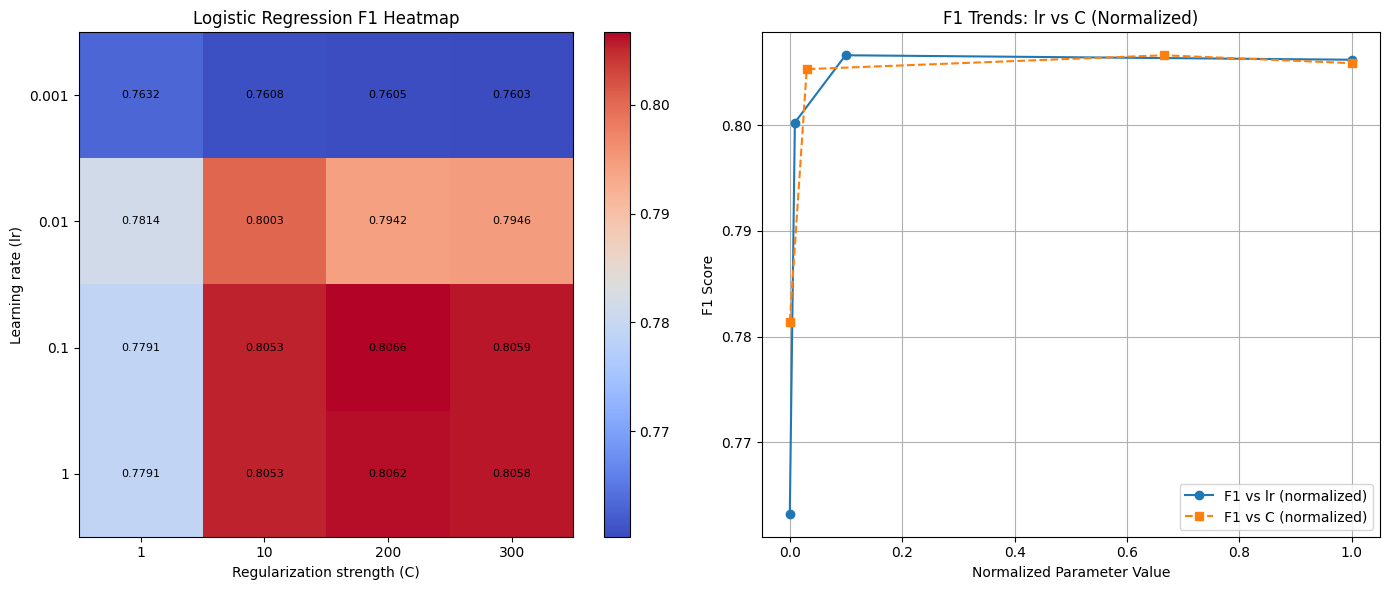

In [248]:
def plot_lr_results(results, lr_values, C_values):

    def normalize(values):
        arr = np.array(values)
        return (arr - arr.min()) / (arr.max() - arr.min())

    flat_results = {
        (dict(k)['lr'], dict(k)['C']): v
        for k, v in results.items()
    }

    f1_matrix = np.array([
        [flat_results.get((lr, C), np.nan) for C in C_values]
        for lr in lr_values
    ])

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    im = axs[0].imshow(f1_matrix, cmap="coolwarm", aspect='auto')
    axs[0].set_xticks(np.arange(len(C_values)))
    axs[0].set_yticks(np.arange(len(lr_values)))
    axs[0].set_xticklabels(C_values)
    axs[0].set_yticklabels(lr_values)
    axs[0].set_xlabel("Regularization strength (C)")
    axs[0].set_ylabel("Learning rate (lr)")
    axs[0].set_title("Logistic Regression F1 Heatmap")
    plt.colorbar(im, ax=axs[0])

    for i in range(len(lr_values)):
        for j in range(len(C_values)):
            val = f1_matrix[i, j]
            text = f"{val:.4f}" if not np.isnan(val) else "NA"
            axs[0].text(j, i, text, ha="center", va="center", fontsize=8, color='black')

    best_f1_per_lr = [max([flat_results.get((lr, c), 0) for c in C_values]) for lr in lr_values]
    best_f1_per_C = [max([flat_results.get((lr, c), 0) for lr in lr_values]) for c in C_values]

    norm_lr = normalize(lr_values)
    norm_C = normalize(C_values)

    axs[1].plot(norm_lr, best_f1_per_lr, marker='o', label='F1 vs lr (normalized)')
    axs[1].plot(norm_C, best_f1_per_C, marker='s', linestyle='--', label='F1 vs C (normalized)')

    axs[1].set_xlabel("Normalized Parameter Value")
    axs[1].set_ylabel("F1 Score")
    axs[1].set_title("F1 Trends: lr vs C (Normalized)")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

results = lr_grid.cv_results_

lr_tuning_results = {
    tuple(sorted((k, v) for k, v in p.items() if k in ['lr', 'C'])): f1
    for p, f1 in zip(results['params'], results['mean_test_score'])
}

lr_values = sorted(set(p['lr'] for p in results['params']))
C_values = sorted(set(p['C'] for p in results['params']))

plot_lr_results(lr_tuning_results, lr_values, C_values)

In [281]:
print(best_lr_params)

{'C': 200, 'lr': 0.1}


SVM tuning with Grid Search 3-Fold-CV \\
_hyperparameters: learning rate, regularization parameter (C)_

In [81]:
fixed_iter = 100

svm_param_grid = {
    'lr': [0.0001, 0.001, 0.01],
    'C': [1, 10, 100, 150]
}

svm_grid = GridSearchCV(
    SVMScratchWrapper(n_iter=fixed_iter),
    svm_param_grid,
    cv=3,
    scoring='f1',
    verbose=2
)

svm_grid.fit(X_train, y_train)
best_svm_params = svm_grid.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .....................................C=1, lr=0.0001; total time=   3.9s
[CV] END .....................................C=1, lr=0.0001; total time=   4.5s
[CV] END .....................................C=1, lr=0.0001; total time=   3.6s
[CV] END ......................................C=1, lr=0.001; total time=   3.4s
[CV] END ......................................C=1, lr=0.001; total time=   4.5s
[CV] END ......................................C=1, lr=0.001; total time=   3.5s
[CV] END .......................................C=1, lr=0.01; total time=   3.5s
[CV] END .......................................C=1, lr=0.01; total time=   4.0s
[CV] END .......................................C=1, lr=0.01; total time=   4.0s
[CV] END ....................................C=10, lr=0.0001; total time=   4.3s
[CV] END ....................................C=10, lr=0.0001; total time=   3.6s
[CV] END ....................................C=1

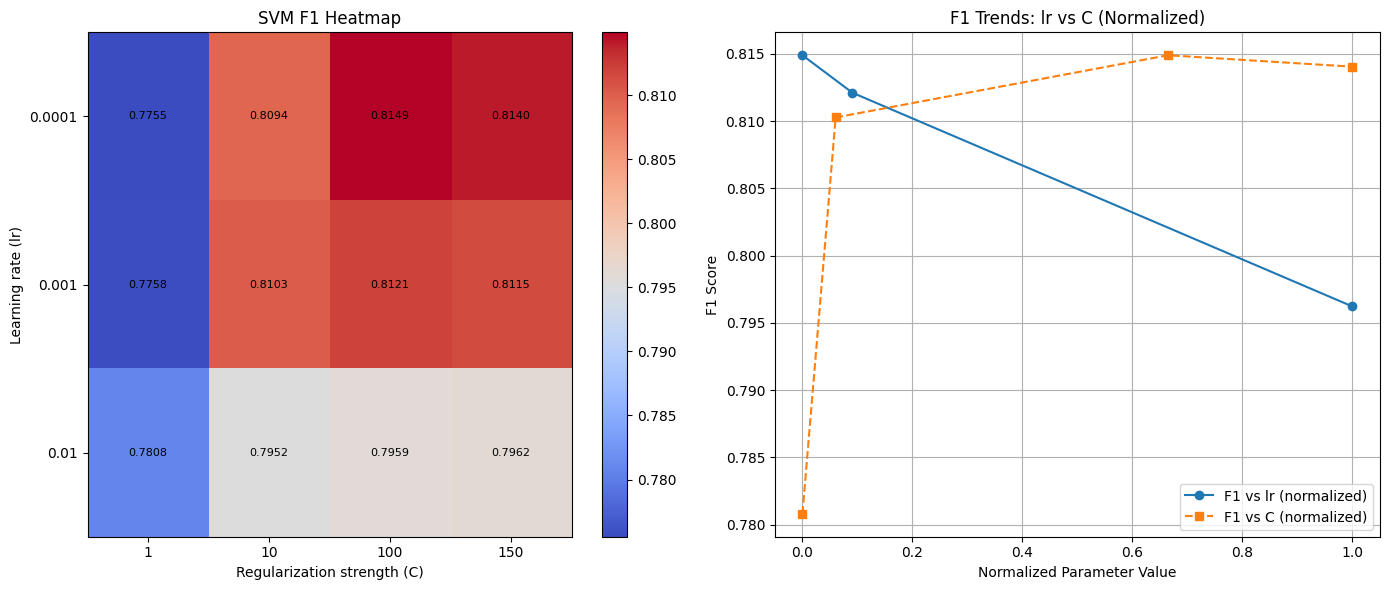

In [82]:
def plot_svm_results(results, lr_values, C_values):

    def normalize(values):
        arr = np.array(values)
        return (arr - arr.min()) / (arr.max() - arr.min())

    flat_results = {
        (dict(k)['lr'], dict(k)['C']): v
        for k, v in results.items()
    }

    f1_matrix = np.array([
        [flat_results.get((lr, C), np.nan) for C in C_values]
        for lr in lr_values
    ])

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    im = axs[0].imshow(f1_matrix, cmap="coolwarm", aspect='auto')
    axs[0].set_xticks(np.arange(len(C_values)))
    axs[0].set_yticks(np.arange(len(lr_values)))
    axs[0].set_xticklabels(C_values)
    axs[0].set_yticklabels(lr_values)
    axs[0].set_xlabel("Regularization strength (C)")
    axs[0].set_ylabel("Learning rate (lr)")
    axs[0].set_title("SVM F1 Heatmap")
    plt.colorbar(im, ax=axs[0])

    for i in range(len(lr_values)):
        for j in range(len(C_values)):
            val = f1_matrix[i, j]
            text = f"{val:.4f}" if not np.isnan(val) else "NA"
            axs[0].text(j, i, text, ha="center", va="center", fontsize=8, color='black')

    best_f1_per_lr = [max([flat_results.get((lr, c), 0) for c in C_values]) for lr in lr_values]
    best_f1_per_C = [max([flat_results.get((lr, c), 0) for lr in lr_values]) for c in C_values]

    norm_lr = normalize(lr_values)
    norm_C = normalize(C_values)

    axs[1].plot(norm_lr, best_f1_per_lr, marker='o', label='F1 vs lr (normalized)')
    axs[1].plot(norm_C, best_f1_per_C, marker='s', linestyle='--', label='F1 vs C (normalized)')

    axs[1].set_xlabel("Normalized Parameter Value")
    axs[1].set_ylabel("F1 Score")
    axs[1].set_title("F1 Trends: lr vs C (Normalized)")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

svm_results = svm_grid.cv_results_

svm_tuning_results = {
    tuple(sorted((k, v) for k, v in p.items() if k in ['lr', 'C'])): f1
    for p, f1 in zip(svm_results['params'], svm_results['mean_test_score'])
}

lr_values = sorted(set(p['lr'] for p in svm_results['params']))
C_values = sorted(set(p['C'] for p in svm_results['params']))

plot_svm_results(svm_tuning_results, lr_values, C_values)

In [280]:
print(best_svm_params)

{'C': 100, 'lr': 0.0001}


### Training, evaluation (5-Fold-CV) and comparison


Training and evaluation function

In [44]:
def train_eval_cv(model_class, X, y, params, k=5, model_name="Model"):
    kf = KFold(n_splits=k, shuffle=True, random_state=1)

    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'confusions': [],
        'confusions_percent': [],
        'classification_reports': [],
        'train_time': [],
        'train_loss_curves': [],
        'train_acc_curves': [],
        'accuracy_gap_per_fold': [],
        'misclassified_examples': []
    }

    for fold, (train_idx, val_idx) in enumerate(tqdm(kf.split(X), total=k)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = model_class(**params)

        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()
        elapsed = end - start
        metrics['train_time'].append(elapsed)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        try:
            val_loss = (
                log_loss(y_val, model.predict_proba(X_val))
                if hasattr(model, "predict_proba")
                else np.nan
            )
        except:
            val_loss = np.nan

        train_loss = (
            model.train_losses[-1] if hasattr(model, "train_losses") and model.train_losses
            else np.nan
        )

        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        prec = precision_score(y_val, y_val_pred, zero_division=0)
        rec = recall_score(y_val, y_val_pred, zero_division=0)
        f1 = f1_score(y_val, y_val_pred, zero_division=0)
        conf = confusion_matrix(y_val, y_val_pred)

        print(f"Fold {fold+1}: Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f} | Time = {elapsed:.2f}s")

        metrics['train_loss'].append(train_loss)
        metrics['val_loss'].append(val_loss)
        metrics['train_accuracy'].append(train_acc)
        metrics['val_accuracy'].append(val_acc)
        metrics['precision'].append(prec)
        metrics['recall'].append(rec)
        metrics['f1'].append(f1)
        metrics['confusions'].append(conf)
        metrics['accuracy_gap_per_fold'].append(train_acc - val_acc)

        if hasattr(model, "train_losses") and model.train_losses:
            metrics['train_loss_curves'].append(np.array(model.train_losses))
        if hasattr(model, "train_accuracies") and model.train_accuracies:
            metrics['train_acc_curves'].append(np.array(model.train_accuracies))

        mis_mask = y_val != y_val_pred
        mis_examples = {
            "indices": val_idx[mis_mask],
            "true_labels": y_val[mis_mask],
            "pred_labels": y_val_pred[mis_mask],
            "features": X_val[mis_mask],
        }
        metrics['misclassified_examples'].append(mis_examples)

        conf_percent = (conf / conf.sum(axis=1, keepdims=True)) * 100
        metrics['confusions_percent'].append(conf_percent)

        report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
        metrics['classification_reports'].append(report)

        metrics.setdefault("val_features", []).append(X_val)
        metrics.setdefault("val_labels", []).append(y_val)
        metrics.setdefault("val_preds", []).append(y_val_pred)

        if metrics['train_loss_curves']:
            min_len = min(len(l) for l in metrics['train_loss_curves'])
            trimmed = [loss[:min_len] for loss in metrics['train_loss_curves']]
            metrics['avg_train_loss_curve'] = np.mean(trimmed, axis=0)
        else:
            metrics['avg_train_loss_curve'] = np.array([])

        if metrics['train_acc_curves']:
            min_len = min(len(a) for a in metrics['train_acc_curves'])
            trimmed = [acc[:min_len] for acc in metrics['train_acc_curves']]
            metrics['avg_train_acc_curve'] = np.mean(trimmed, axis=0)
        else:
            metrics['avg_train_acc_curve'] = np.array([])

    return metrics

Logistic Regression training and evaluation using 5-Fold-CV

In [126]:
summary_lr = train_eval_cv(LogisticRegressionScratch, X, y, best_lr_params, model_name="Logistic Regression")

 20%|██        | 1/5 [00:01<00:04,  1.14s/it]

Fold 1: Train Acc = 0.7458 | Val Acc = 0.7300 | Time = 1.12s


 40%|████      | 2/5 [00:02<00:02,  1.02it/s]

Fold 2: Train Acc = 0.7364 | Val Acc = 0.7523 | Time = 0.85s


 60%|██████    | 3/5 [00:02<00:01,  1.07it/s]

Fold 3: Train Acc = 0.7424 | Val Acc = 0.7213 | Time = 0.85s


 80%|████████  | 4/5 [00:03<00:00,  1.11it/s]

Fold 4: Train Acc = 0.7418 | Val Acc = 0.7390 | Time = 0.84s


100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

Fold 5: Train Acc = 0.7386 | Val Acc = 0.7513 | Time = 0.84s


SVM training and evaluation using 5-Fold-CV

In [79]:
summary_svm = train_eval_cv(SVMScratch, X, y, best_svm_params, model_name="SVM")

 20%|██        | 1/5 [00:51<03:27, 51.85s/it]

Fold 1: Train Acc = 0.7495 | Val Acc = 0.7377 | Time = 51.83s


 40%|████      | 2/5 [01:44<02:36, 52.20s/it]

Fold 2: Train Acc = 0.7456 | Val Acc = 0.7585 | Time = 52.43s


 60%|██████    | 3/5 [02:35<01:43, 51.67s/it]

Fold 3: Train Acc = 0.7520 | Val Acc = 0.7352 | Time = 51.03s


 80%|████████  | 4/5 [03:27<00:51, 51.85s/it]

Fold 4: Train Acc = 0.7505 | Val Acc = 0.7429 | Time = 52.10s


100%|██████████| 5/5 [04:19<00:00, 51.89s/it]

Fold 5: Train Acc = 0.7436 | Val Acc = 0.7660 | Time = 51.98s


#### Training curves

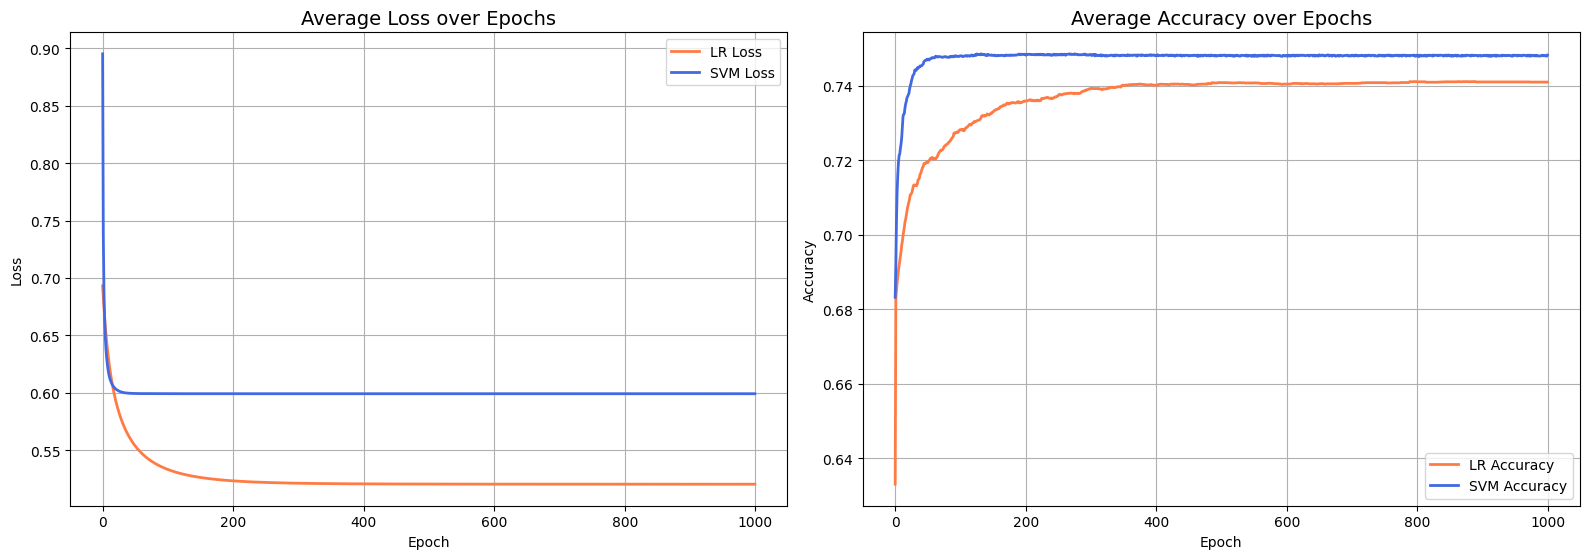

In [128]:
def plot_compare_training_curves(loss_svm, acc_svm, loss_lr, acc_lr):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(loss_lr, label="LR Loss", color='#ff7b43', linewidth=2)
    axs[0].plot(loss_svm, label="SVM Loss", color='#4169e1', linewidth=2)
    axs[0].set_title("Average Loss over Epochs", fontsize=14)
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(acc_lr, label="LR Accuracy", color='#ff7b43', linewidth=2)
    axs[1].plot(acc_svm, label="SVM Accuracy", color='#4169e1', linewidth=2)
    axs[1].set_title("Average Accuracy over Epochs", fontsize=14)
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_compare_training_curves(summary_svm['avg_train_loss_curve'], summary_svm['avg_train_acc_curve'], summary_lr['avg_train_loss_curve'], summary_lr['avg_train_acc_curve'])

In [129]:
def analyze_train_curves(metrics, model_name="Model"):
    loss_curve = metrics.get("avg_train_loss_curve", [])
    acc_curve = metrics.get("avg_train_acc_curve", [])

    print(f"\n{model_name} per-epoch training curve summary (averaged over folds)")

    if len(loss_curve) > 1:
        min_loss = np.min(loss_curve)
        final_loss = loss_curve[-1]
        loss_drop_pct = 100 * (loss_curve[0] - final_loss) / loss_curve[0]
        loss_stability = np.abs(loss_curve[-1] - loss_curve[-5]) if len(loss_curve) >= 6 else np.abs(loss_curve[-1] - loss_curve[0])

        print(f"\n Train loss:")
        print(f"  • first epoch: {loss_curve[0]:.4f}")
        print(f"  • final epoch: {final_loss:.4f}")
        print(f"  • min loss: {min_loss:.4f}")
        print(f"  • total drop: {loss_drop_pct:.2f}%")
        print(f"  • final 5-epoch change: {loss_stability:.4f}")
        print("  • trend:", "stable" if loss_stability < 0.005 else "still changing")

    if len(acc_curve) > 1:
        first_acc = acc_curve[0]
        final_acc = acc_curve[-1]
        acc_gain_pct = 100 * (final_acc - first_acc) / first_acc
        acc_stability = np.abs(acc_curve[-1] - acc_curve[-5]) if len(acc_curve) >= 6 else np.abs(acc_curve[-1] - acc_curve[0])

        print(f"\n Train accuracy:")
        print(f"  • first epoch: {first_acc:.4f}")
        print(f"  • final epoch: {final_acc:.4f}")
        print(f"  • total gain: +{acc_gain_pct:.2f}%")
        print(f"  • final 5-epoch change: {acc_stability:.4f}")
        print("  • trend:", "stable" if acc_stability < 0.005 else "still improving")

analyze_train_curves(summary_lr, "Logistic Regression")
analyze_train_curves(summary_svm, "SVM")


Logistic Regression per-epoch training curve summary (averaged over folds)

 Train loss:
  • first epoch: 0.6931
  • final epoch: 0.5204
  • min loss: 0.5204
  • total drop: 24.92%
  • final 5-epoch change: 0.0000
  • trend: stable

 Train accuracy:
  • first epoch: 0.6331
  • final epoch: 0.7410
  • total gain: +17.05%
  • final 5-epoch change: 0.0000
  • trend: stable

SVM per-epoch training curve summary (averaged over folds)

 Train loss:
  • first epoch: 0.8951
  • final epoch: 0.5992
  • min loss: 0.5992
  • total drop: 33.06%
  • final 5-epoch change: 0.0000
  • trend: stable

 Train accuracy:
  • first epoch: 0.6832
  • final epoch: 0.7482
  • total gain: +9.51%
  • final 5-epoch change: 0.0001
  • trend: stable


#### Classification Metrics

Average Precision, Recall, F1, Val accuracy comparison

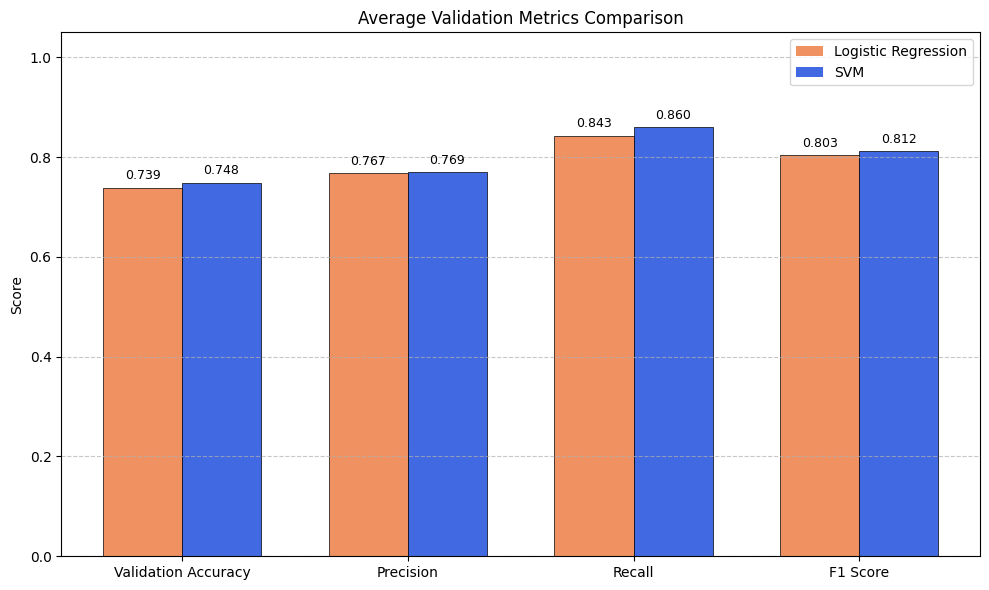

In [127]:
def plot_metric_histograms(metrics_lr, metrics_svm):
    metrics_names = ['val_accuracy', 'precision', 'recall', 'f1']
    labels = ['Validation Accuracy', 'Precision', 'Recall', 'F1 Score']

    lr_means = [np.mean(metrics_lr[m]) for m in metrics_names]
    svm_means = [np.mean(metrics_svm[m]) for m in metrics_names]

    x = np.arange(len(metrics_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10,6))
    rects1 = ax.bar(x - width/2, lr_means, width, label='Logistic Regression', color='#f09162')
    rects2 = ax.bar(x + width/2, svm_means, width, label='SVM', color='#4169e1')

    ax.set_ylabel('Score')
    ax.set_title('Average Validation Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in ax.patches:
        bar.set_edgecolor('black')
        bar.set_linewidth(0.5)

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

plot_metric_histograms(summary_lr, summary_svm)

#### Confusion matrices + misclassifications

Average confusion matrices

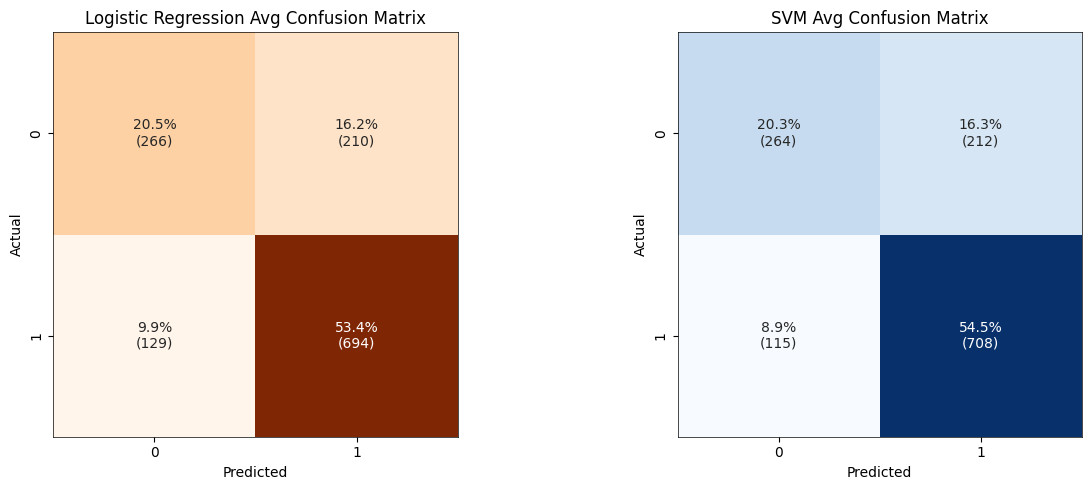

In [141]:
def plot_avg_conf_matrices(avg_cm_lr, avg_cm_svm):

    int_cm_lr = np.rint(avg_cm_lr).astype(int)
    int_cm_svm = np.rint(avg_cm_svm).astype(int)

    percent_cm_lr = avg_cm_lr / np.sum(avg_cm_lr) * 100
    percent_cm_svm = avg_cm_svm / np.sum(avg_cm_svm) * 100

    def make_labels(percent_cm, int_cm):
        labels = []
        for i in range(percent_cm.shape[0]):
            row = []
            for j in range(percent_cm.shape[1]):
                perc = f"{percent_cm[i, j]:.1f}%"
                count = f"({int(int_cm[i, j])})"
                row.append(f"{perc}\n{count}")
            labels.append(row)
        return np.array(labels)

    labels_lr = make_labels(percent_cm_lr, int_cm_lr)
    labels_svm = make_labels(percent_cm_svm, int_cm_svm)

    fig, axs = plt.subplots(1, 2, figsize=(13, 5))

    sns.heatmap(percent_cm_lr, annot=labels_lr, fmt='', cmap='Oranges', ax=axs[0], cbar=False, square=True)
    axs[0].set_title("Logistic Regression Avg Confusion Matrix", fontsize=12)

    sns.heatmap(percent_cm_svm, annot=labels_svm, fmt='', cmap='Blues', ax=axs[1], cbar=False, square=True)
    axs[1].set_title("SVM Avg Confusion Matrix", fontsize=12)

    for ax in axs:
        ax.set_xlabel("Predicted", fontsize=10)
        ax.set_ylabel("Actual", fontsize=10)

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_color('black')

    plt.tight_layout()
    plt.show()

avg_cm_lr = np.mean(summary_lr['confusions'], axis=0)
avg_cm_svm = np.mean(summary_svm['confusions'], axis=0)
plot_avg_conf_matrices(avg_cm_lr, avg_cm_svm)

Average classification reports

In [142]:
def avg_classification_report(classification_reports, model_name="Model"):
    clean_reports = []
    for r in classification_reports:
        if isinstance(r, dict):
            is_clean = True
            for k, v in r.items():
                if isinstance(v, dict):
                    if not all(isinstance(val, (int, float)) for val in v.values()):
                        is_clean = False
                elif not isinstance(v, (int, float)):
                    is_clean = False
            if is_clean:
                clean_reports.append(r)

    print(f"\n{model_name} - Average Classification Report:\n")

    avg_report = {}
    for label in clean_reports[0].keys():
        if isinstance(clean_reports[0][label], dict):
            avg_report[label] = {}
            for metric in clean_reports[0][label]:
                values = [r[label][metric] for r in clean_reports if label in r and isinstance(r[label], dict)]
                avg_report[label][metric] = np.mean(values)
        else:
            values = [r[label] for r in clean_reports if label in r and isinstance(r[label], (int, float))]
            avg_report[label] = np.mean(values)

    df = pd.DataFrame(avg_report).T
    print(df.round(3))

avg_classification_report(summary_lr['classification_reports'], model_name="Logistic Regression")
avg_classification_report(summary_svm['classification_reports'], model_name="SVM")


Logistic Regression - Average Classification Report:

              precision  recall  f1-score   support
0                 0.674   0.559     0.611   476.800
1                 0.767   0.843     0.803   822.600
accuracy          0.739   0.739     0.739     0.739
macro avg         0.721   0.701     0.707  1299.400
weighted avg      0.733   0.739     0.733  1299.400

SVM - Average Classification Report:

              precision  recall  f1-score   support
0                 0.697   0.555     0.618   476.800
1                 0.769   0.860     0.812   822.600
accuracy          0.748   0.748     0.748     0.748
macro avg         0.733   0.708     0.715  1299.400
weighted avg      0.743   0.748     0.741  1299.400


Feature mean differences

In [143]:
def get_feature_mean_differences(metrics, feature_names, model_name="Model"):
    all_mis_features = []
    all_correct_features = []

    for i in range(len(metrics['misclassified_examples'])):
        mis_feats = metrics['misclassified_examples'][i]['features']
        all_mis_features.append(mis_feats)

        X_val = metrics['val_features'][i]
        y_val = metrics['val_labels'][i]
        y_pred = metrics['val_preds'][i]
        correct_mask = y_val == y_pred
        correct_feats = X_val[correct_mask]
        all_correct_features.append(correct_feats)

    all_mis_features = np.vstack(all_mis_features)
    all_correct_features = np.vstack(all_correct_features)

    mis_means = all_mis_features.mean(axis=0)
    correct_means = all_correct_features.mean(axis=0)
    diff_means = mis_means - correct_means

    df = pd.DataFrame({
        "Feature": feature_names,
        "Misclassified Mean": mis_means,
        "Correct Mean": correct_means,
        "Diff": diff_means
    }).sort_values(by="Diff", key=np.abs, ascending=False)

    print(f"\n{model_name} - Feature Mean Differences:\n")
    print(df)

    return df

feature_names = list(df.columns)
feature_names.remove('label')
feature_names.remove('quality')

lr_feat_diff_df = get_feature_mean_differences(summary_lr, feature_names, "Logistic Regression")
svm_feat_diff_df = get_feature_mean_differences(summary_svm, feature_names, "SVM")


Logistic Regression - Feature Mean Differences:

                 Feature  Misclassified Mean  Correct Mean      Diff
10               alcohol           -0.395671      0.139886 -0.535557
7                density            0.309618     -0.109463  0.419081
3         residual sugar            0.157905     -0.055826  0.213732
4              chlorides            0.115741     -0.040919  0.156661
6   total sulfur dioxide            0.101417     -0.035855  0.137273
8                     pH           -0.078897      0.027893 -0.106791
0          fixed acidity            0.076106     -0.026907  0.103013
9              sulphates           -0.031573      0.011162 -0.042735
2            citric acid           -0.010060      0.003557 -0.013616
11                  type           -0.005944      0.002102 -0.008046
5    free sulfur dioxide           -0.000862      0.000305 -0.001167
1       volatile acidity            0.000579     -0.000205  0.000784

SVM - Feature Mean Differences:

                 Fe

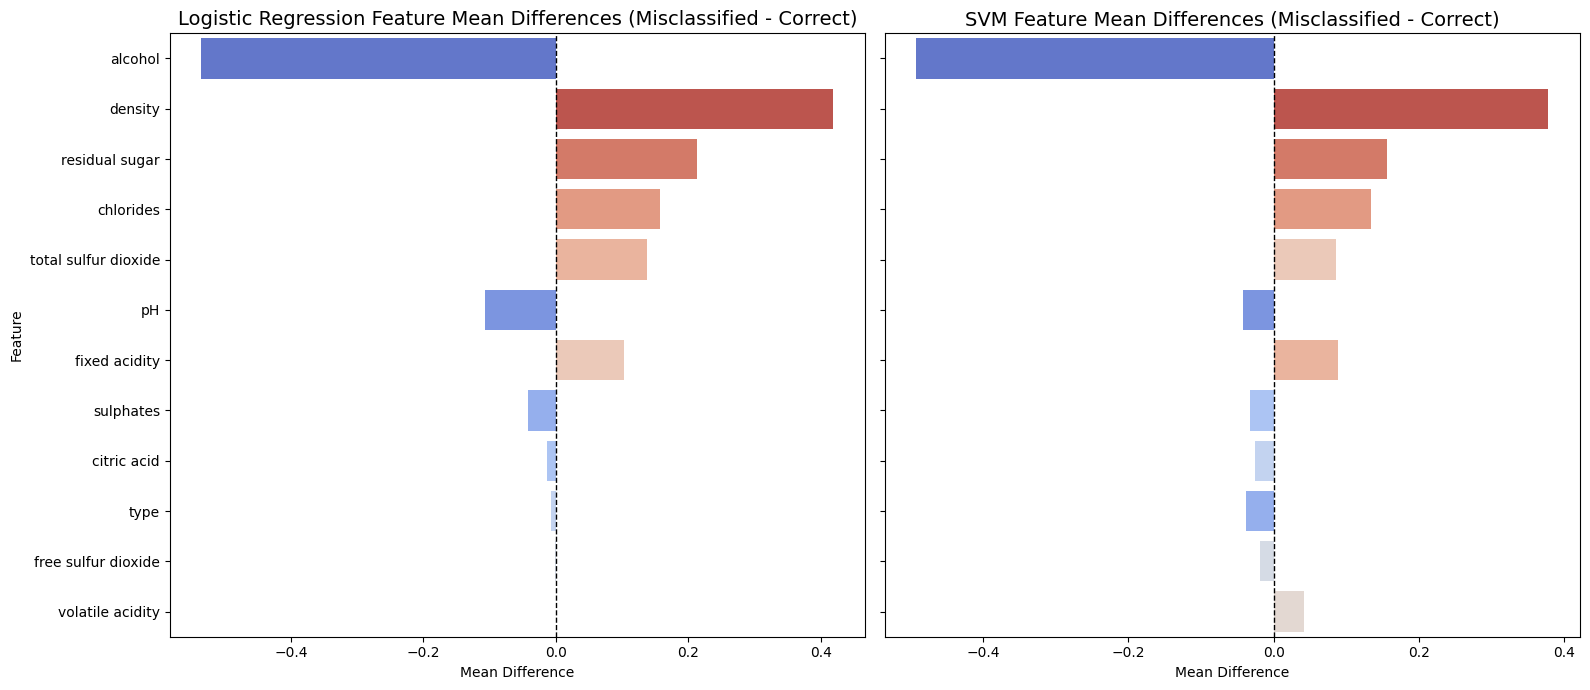

In [144]:
def plot_feature_mean_differences_side_by_side(df1, df2, model_name1="Model 1", model_name2="Model 2"):
    fig, axs = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

    sns.barplot(
        data=df1,
        y="Feature",
        x="Diff",
        hue="Diff",
        palette=sns.color_palette("coolwarm", n_colors=len(df1)),
        dodge=False,
        ax=axs[0],
        legend=False
    )
    axs[0].axvline(0, color='black', linestyle='--', linewidth=1)
    axs[0].set_title(f"{model_name1} Feature Mean Differences (Misclassified - Correct)", fontsize=14)
    axs[0].set_xlabel("Mean Difference")
    axs[0].set_ylabel("Feature")

    sns.barplot(
        data=df2,
        y="Feature",
        x="Diff",
        hue="Diff",
        palette=sns.color_palette("coolwarm", n_colors=len(df1)),
        dodge=False,
        ax=axs[1],
        legend=False
    )
    axs[1].axvline(0, color='black', linestyle='--', linewidth=1)
    axs[1].set_title(f"{model_name2} Feature Mean Differences (Misclassified - Correct)", fontsize=14)
    axs[1].set_xlabel("Mean Difference")
    axs[1].set_ylabel("")

    plt.tight_layout()
    plt.show()

plot_feature_mean_differences_side_by_side(lr_feat_diff_df, svm_feat_diff_df, "Logistic Regression", "SVM")

#### Overfitting gaps

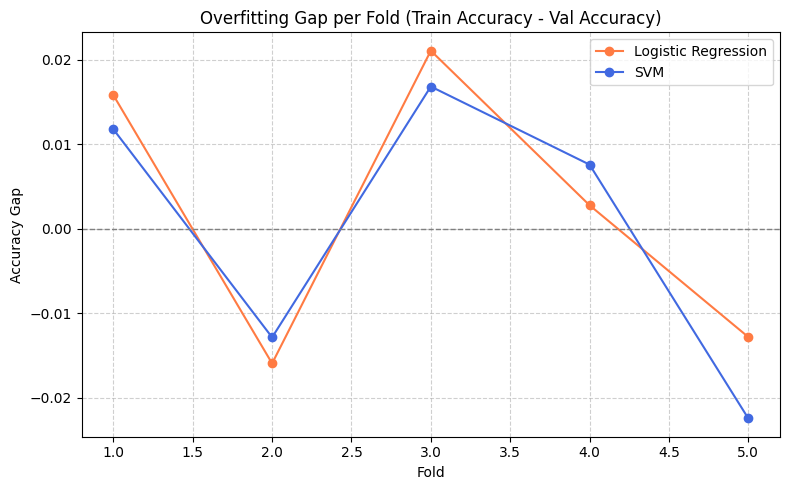

In [130]:
def plot_overfitting_gaps_comparison(metrics_lr, metrics_svm):
    gap_lr = np.array(metrics_lr['train_accuracy']) - np.array(metrics_lr['val_accuracy'])
    gap_svm = np.array(metrics_svm['train_accuracy']) - np.array(metrics_svm['val_accuracy'])

    folds = np.arange(1, len(gap_lr) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(folds, gap_lr, marker='o', label='Logistic Regression', color='#ff7b43')
    plt.plot(folds, gap_svm, marker='o', label='SVM', color='#4169e1')

    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title("Overfitting Gap per Fold (Train Accuracy - Val Accuracy)")
    plt.xlabel("Fold")
    plt.ylabel("Accuracy Gap")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_overfitting_gaps_comparison(summary_lr, summary_svm)

Overfitting analysis

In [131]:
def analyse_overfitting(metrics, model_name="Model"):
    gaps = np.array(metrics['train_accuracy']) - np.array(metrics['val_accuracy'])
    min_gap = np.min(gaps)
    max_gap = np.max(gaps)
    mean_gap = np.mean(gaps)
    std_gap = np.std(gaps)
    train_acc = np.array(metrics.get('train_accuracy', []))
    val_acc = np.array(metrics.get('val_accuracy', []))
    train_loss = np.array(metrics.get('train_loss', []))

    bias = np.mean(train_acc) - np.mean(val_acc)
    variance = np.std(val_acc)
    acc_gap = train_acc - val_acc

    print(f"\n{model_name} Overfitting Analysis:")
    print(f"  Min Overfitting Gap: {min_gap:.4f}")
    print(f"  Max Overfitting Gap: {max_gap:.4f}")
    print(f"  Mean Overfitting Gap: {mean_gap:.4f}")
    print(f"  Std Dev Overfitting Gap: {std_gap:.4f}")
    print(f"  Bias Estimate: {bias:.4f}")
    print(f"  Variance Estimate: {variance:.4f}")
    print(f"  Mean Accuracy Gap: {np.mean(acc_gap):.4f}")
    print(f"  Variance of Accuracy Gap: {np.var(acc_gap):.4f}")

analyse_overfitting(summary_lr, model_name="Logistic Regression")
analyse_overfitting(summary_svm, model_name="SVM")


Logistic Regression Overfitting Analysis:
  Min Overfitting Gap: -0.0159
  Max Overfitting Gap: 0.0211
  Mean Overfitting Gap: 0.0022
  Std Dev Overfitting Gap: 0.0148
  Bias Estimate: 0.0022
  Variance Estimate: 0.0120
  Mean Accuracy Gap: 0.0022
  Variance of Accuracy Gap: 0.0002

SVM Overfitting Analysis:
  Min Overfitting Gap: -0.0224
  Max Overfitting Gap: 0.0168
  Mean Overfitting Gap: 0.0002
  Std Dev Overfitting Gap: 0.0151
  Bias Estimate: 0.0002
  Variance Estimate: 0.0121
  Mean Accuracy Gap: 0.0002
  Variance of Accuracy Gap: 0.0002


#### Other stats

In [132]:
def print_advanced_cv_metrics(metrics, model_name="Model"):
    n_folds = len(metrics['train_accuracy'])
    print(f"\n {model_name} Cross-Validation Metrics + Advanced Stats \n")

    for i in range(n_folds):
        print(f"Fold {i+1}:")
        print(f"  Train Loss: {metrics['train_loss'][i]:.4f}")
        print(f"  Val Loss: {metrics['val_loss'][i]:.4f}")
        print(f"  Train Accuracy: {metrics['train_accuracy'][i]:.4f}")
        print(f"  Val Accuracy: {metrics['val_accuracy'][i]:.4f}")
        print(f"  Precision: {metrics['precision'][i]:.4f}")
        print(f"  Recall: {metrics['recall'][i]:.4f}")
        print(f"  F1 Score: {metrics['f1'][i]:.4f}")
        print(f"  Accuracy Gap (Train - Val): {metrics['accuracy_gap_per_fold'][i]:.4f}")
        print(f"  Confusion Matrix:\n{metrics['confusions'][i]}")
        print("")

    mean_train_acc = np.mean(metrics['train_accuracy'])
    mean_val_acc = np.mean(metrics['val_accuracy'])
    mean_train_loss = np.mean(metrics['train_loss'])
    mean_val_loss = np.mean(metrics['val_loss'])
    mean_precision = np.mean(metrics['precision'])
    mean_recall = np.mean(metrics['recall'])
    mean_f1 = np.mean(metrics['f1'])
    mean_acc_gap = np.mean(metrics['accuracy_gap_per_fold'])
    mean_train_time = np.mean(metrics['train_time'])

    std_train_acc = np.std(metrics['train_accuracy'])
    std_val_acc = np.std(metrics['val_accuracy'])
    std_train_loss = np.std(metrics['train_loss'])
    std_val_loss = np.std(metrics['val_loss'])
    std_precision = np.std(metrics['precision'])
    std_recall = np.std(metrics['recall'])
    std_f1 = np.std(metrics['f1'])
    std_acc_gap = np.std(metrics['accuracy_gap_per_fold'])
    std_train_time = np.std(metrics['train_time'])

    bias_estimate = 1.0 - mean_train_acc

    variance_estimate = std_val_acc

    print(f"  Average Metrics Across {n_folds} Folds")
    print(f"  Train Loss: {mean_train_loss:.4f} ± {std_train_loss:.4f}")
    print(f"  Val Loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")
    print(f"  Train Accuracy: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
    print(f"  Val Accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")
    print(f"  Precision: {mean_precision:.4f} ± {std_precision:.4f}")
    print(f"  Recall: {mean_recall:.4f} ± {std_recall:.4f}")
    print(f"  F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"  Accuracy Gap (Train - Val): {mean_acc_gap:.4f} ± {std_acc_gap:.4f}")
    print(f"  Training Time: {mean_train_time:.2f}s ± {std_train_time:.2f}s\n")

    print(f" Bias Estimate (1 - Train Acc): {bias_estimate:.4f}  (higher → underfitting)")
    print(f" Variance Estimate (Std Dev Val Acc): {variance_estimate:.4f}  (higher → overfitting)\n")

print_advanced_cv_metrics(summary_lr, model_name="Logistic Regression")
print_advanced_cv_metrics(summary_svm, model_name="SVM")


 Logistic Regression Cross-Validation Metrics + Advanced Stats 

Fold 1:
  Train Loss: 0.5169
  Val Loss: 0.5313
  Train Accuracy: 0.7458
  Val Accuracy: 0.7300
  Precision: 0.7527
  Recall: 0.8462
  F1 Score: 0.7968
  Accuracy Gap (Train - Val): 0.0158
  Confusion Matrix:
[[261 226]
 [125 688]]

Fold 2:
  Train Loss: 0.5236
  Val Loss: 0.5047
  Train Accuracy: 0.7364
  Val Accuracy: 0.7523
  Precision: 0.7833
  Recall: 0.8474
  F1 Score: 0.8141
  Accuracy Gap (Train - Val): -0.0159
  Confusion Matrix:
[[273 195]
 [127 705]]

Fold 3:
  Train Loss: 0.5162
  Val Loss: 0.5343
  Train Accuracy: 0.7424
  Val Accuracy: 0.7213
  Precision: 0.7489
  Recall: 0.8254
  F1 Score: 0.7853
  Accuracy Gap (Train - Val): 0.0211
  Confusion Matrix:
[[275 222]
 [140 662]]

Fold 4:
  Train Loss: 0.5206
  Val Loss: 0.5168
  Train Accuracy: 0.7418
  Val Accuracy: 0.7390
  Precision: 0.7606
  Recall: 0.8561
  F1 Score: 0.8055
  Accuracy Gap (Train - Val): 0.0028
  Confusion Matrix:
[[258 221]
 [118 702]]

F

## Non-Linear Kernel Methods

### Model definition

Logistic Regression Kernel extension

In [250]:
class KernelLogisticRegression:
    def __init__(self, lr=0.1, n_iter=100, kernel='rbf',
                 gamma=1.0, degree=3, coeff0=1.0, C=1.0):
        self.lr = lr
        self.n_iter = n_iter
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coeff0 = coeff0
        self.C = C
        self.train_losses = []
        self.train_accuracies = []

    def _kernel_function(self, x1, x2):
        if self.kernel == 'linear':
            return np.dot(x1, x2)
        elif self.kernel == 'rbf':
            return np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)
        elif self.kernel == 'poly':
            return (np.dot(x1, x2) + self.coeff0) ** self.degree
        else:
            raise ValueError("unsupported kernel")

    def _compute_kernel_matrix(self, X):
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self._kernel_function(X[i], X[j])
        return K

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        n_samples = X.shape[0]
        self.K = self._compute_kernel_matrix(X)
        self.alpha = np.zeros(n_samples)
        lambda_reg = 1 / self.C

        for _ in range(self.n_iter):
            f = self.K.dot(self.alpha)
            prob = self._sigmoid(f)

            grad = self.K.T.dot(prob - y) / n_samples + lambda_reg * self.alpha
            self.alpha -= self.lr * grad

            loss = -np.mean(y * np.log(prob + 1e-15) + (1 - y) * np.log(1 - prob + 1e-15))
            loss += 0.5 * lambda_reg * np.sum(self.alpha ** 2)
            self.train_losses.append(loss)

            preds = (prob >= 0.5).astype(int)
            acc = np.mean(preds == y)
            self.train_accuracies.append(acc)

    def predict_proba(self, X):
        K_test = np.array([
            [self._kernel_function(x, x_train) for x_train in self.X_train]
            for x in X
        ])
        return self._sigmoid(K_test.dot(self.alpha))

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

SVM Kernel extension

In [228]:
class KernelSVM:
    def __init__(self, kernel='linear', degree=3, gamma=0.1, coef0=1,
                 learning_rate=0.01, C=100, n_iter=100):
        self.kernel_type = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.lr = learning_rate
        self.C = C
        self.n_iter = n_iter
        self.train_losses = []
        self.train_accuracies = []

    def _kernel(self, X, Y=None):
        if Y is None:
            Y = X
        if self.kernel_type == 'linear':
            return X @ Y.T
        elif self.kernel_type == 'poly':
            return (self.gamma * (X @ Y.T) + self.coef0) ** self.degree
        elif self.kernel_type == 'rbf':
            X_norm = np.sum(X ** 2, axis=1).reshape(-1, 1)
            Y_norm = np.sum(Y ** 2, axis=1).reshape(1, -1)
            dist = X_norm + Y_norm - 2 * np.dot(X, Y.T)
            return np.exp(-self.gamma * dist)
        else:
            raise ValueError("unsupported kernel")

    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.where(y <= 0, -1, 1)
        n_samples = X.shape[0]

        self.alpha = np.zeros(n_samples)
        self.b = 0

        K = self._kernel(X)

        for _ in range(self.n_iter):
            reg_grad_all = (1 / self.C) * np.dot(K, self.alpha * self.y_train) * self.y_train

            hinge_losses = []

            for i in range(n_samples):
                margin = self.y_train[i] * (np.dot(self.alpha * self.y_train, K[:, i]) + self.b)
                if margin < 1:
                    self.alpha[i] -= self.lr * (reg_grad_all[i] - 1)
                    self.b += self.lr * self.y_train[i]
                    hinge_losses.append(1 - margin)
                else:
                    self.alpha[i] -= self.lr * reg_grad_all[i]
                    hinge_losses.append(0)

            reg = (1 / (2 * self.C)) * np.dot(self.alpha * self.y_train, K @ (self.alpha * self.y_train))
            avg_hinge = np.mean(hinge_losses)
            total_loss = reg + avg_hinge
            self.train_losses.append(total_loss)

            preds = self.predict(X)
            acc = np.mean(preds == np.where(self.y_train == -1, 0, 1))
            self.train_accuracies.append(acc)

    def project(self, X):
        K = self._kernel(X, self.X_train)
        return np.dot(K, self.alpha * self.y_train) + self.b

    def predict(self, X):
        return np.where(self.project(X) >= 0, 1, 0)

### Tuning with GridSearchCV (RBF Kernels)

Wrappers for using sklearn with the class from scratch

In [251]:
class KernelLogRegWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel='rbf', lr=0.01, gamma=0.1, degree=3, n_iter=300, C=1.0):
        self.kernel = kernel
        self.lr = lr
        self.gamma = gamma
        self.degree = degree
        self.n_iter = n_iter
        self.C = C
        self.model = None

    def fit(self, X, y):
        self.model = KernelLogisticRegression(
            lr=self.lr,
            gamma=self.gamma,
            kernel=self.kernel,
            degree=self.degree,
            n_iter=self.n_iter,
            C=self.C
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

class KernelSVMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel='rbf', C=1.0, gamma=0.1, degree=3, learning_rate=0.01, n_iter=1000):
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.degree = degree
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.model = None

    def fit(self, X, y):
        self.model = KernelSVM(
            kernel=self.kernel,
            C=self.C,
            gamma=self.gamma,
            degree=self.degree,
            learning_rate=self.learning_rate,
            n_iter=self.n_iter
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

KLR tuning with 2-Fold-CV (warning: runtime may take ~15min) \\
_hyperparameters: gamma, regularization parameter (C)_

In [264]:
gamma_scale = 1 / (X_train.shape[1] * np.var(X_train))

klr_param_grid = {
    'C': [50, 100],
    'gamma': [gamma_scale, 0.01],
    'kernel': ['rbf'],
    'lr': [0.01],
    'n_iter': [100]
}

klr_grid = GridSearchCV(KernelLogRegWrapper(), klr_param_grid, cv=2, scoring='f1', verbose=2)
klr_grid.fit(X_train, y_train)
best_klr_params = klr_grid.best_params_

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END C=50, gamma=0.0822467644891304, kernel=rbf, lr=0.01, n_iter=100; total time= 1.4min
[CV] END C=50, gamma=0.0822467644891304, kernel=rbf, lr=0.01, n_iter=100; total time= 1.8min
[CV] END ..C=50, gamma=0.01, kernel=rbf, lr=0.01, n_iter=100; total time= 1.8min
[CV] END ..C=50, gamma=0.01, kernel=rbf, lr=0.01, n_iter=100; total time= 1.4min
[CV] END C=100, gamma=0.0822467644891304, kernel=rbf, lr=0.01, n_iter=100; total time= 1.5min
[CV] END C=100, gamma=0.0822467644891304, kernel=rbf, lr=0.01, n_iter=100; total time= 1.6min
[CV] END .C=100, gamma=0.01, kernel=rbf, lr=0.01, n_iter=100; total time= 1.7min
[CV] END .C=100, gamma=0.01, kernel=rbf, lr=0.01, n_iter=100; total time= 1.6min


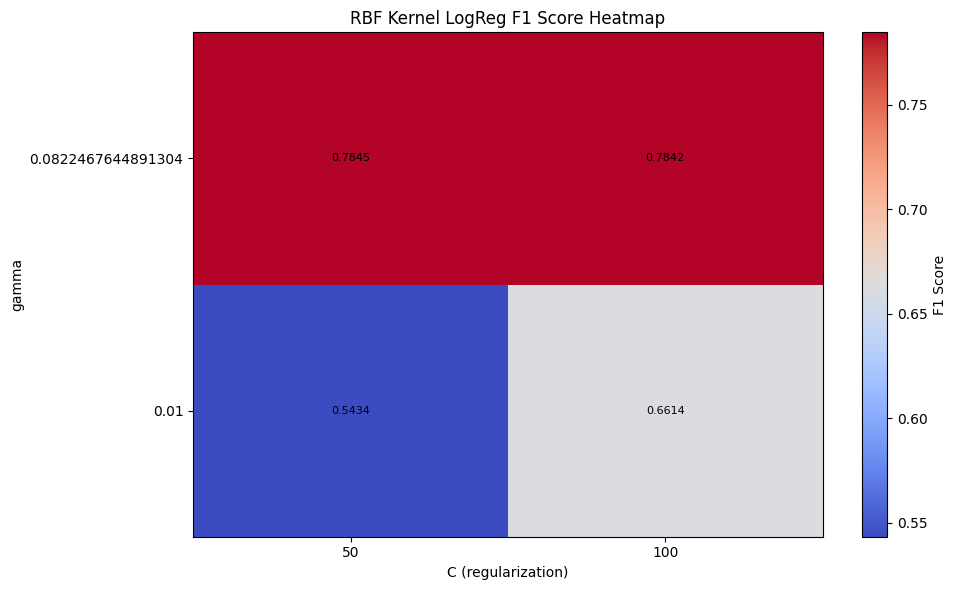

In [265]:
def plot_klr_results(results, c_values, gamma_values):
    f1_matrix = np.array([
        [klr_tuning_results.get((c, g), np.nan) for c in c_values]
        for g in gamma_values
    ])

    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(f1_matrix, cmap="coolwarm", aspect='auto', origin='lower')

    ax.set_xticks(np.arange(len(c_values)))
    ax.set_yticks(np.arange(len(gamma_values)))
    ax.set_xticklabels([str(c) for c in c_values], rotation=0)
    ax.set_yticklabels([str(g) for g in gamma_values])

    ax.set_xlabel("C (regularization)")
    ax.set_ylabel("gamma")
    ax.set_title("RBF Kernel LogReg F1 Score Heatmap")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("F1 Score")

    for i in range(len(gamma_values)):
        for j in range(len(c_values)):
            val = f1_matrix[i, j]
            if not np.isnan(val):
                ax.text(j, i, f"{val:.4f}", ha="center", va="center", color="black", fontsize=8)

    plt.tight_layout()
    plt.show()

results = klr_grid.cv_results_

klr_tuning_results = {
    (p['C'], p['gamma']): f1
    for p, f1 in zip(results['params'], results['mean_test_score'])
}

klr_c_values = sorted(set(p['C'] for p in results['params']))
klr_gamma_values = sorted(set(p['gamma'] for p in results['params']))

plot_klr_results(klr_tuning_results, klr_c_values, klr_gamma_values)

In [266]:
print(best_klr_params)

{'C': 50, 'gamma': np.float64(0.0822467644891304), 'kernel': 'rbf', 'lr': 0.01, 'n_iter': 100}


KSVM tuning with 2-Fold-CV (warning: runtime may take ~10min) \\
_hyperparameters: gamma, learning rate_

In [240]:
gamma_scale = 1 / (X_train.shape[1] * np.var(X_train))

ksvm_param_grid = {
    'C': [100],
    'gamma': [gamma_scale, 0.01, 0.001],
    'kernel': ['rbf'],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_iter': [100]
}

ksvm_grid = GridSearchCV(KernelSVMWrapper(), ksvm_param_grid, cv=2, scoring='f1', verbose=2)
ksvm_grid.fit(X_train, y_train)
best_ksvm_params = ksvm_grid.best_params_

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END C=100, gamma=0.0822467644891304, kernel=rbf, learning_rate=0.001, n_iter=100; total time=  32.2s
[CV] END C=100, gamma=0.0822467644891304, kernel=rbf, learning_rate=0.001, n_iter=100; total time=  32.9s
[CV] END C=100, gamma=0.0822467644891304, kernel=rbf, learning_rate=0.01, n_iter=100; total time=  31.9s
[CV] END C=100, gamma=0.0822467644891304, kernel=rbf, learning_rate=0.01, n_iter=100; total time=  31.7s
[CV] END C=100, gamma=0.0822467644891304, kernel=rbf, learning_rate=0.1, n_iter=100; total time=  31.7s
[CV] END C=100, gamma=0.0822467644891304, kernel=rbf, learning_rate=0.1, n_iter=100; total time=  32.3s
[CV] END C=100, gamma=0.01, kernel=rbf, learning_rate=0.001, n_iter=100; total time=  30.7s
[CV] END C=100, gamma=0.01, kernel=rbf, learning_rate=0.001, n_iter=100; total time=  33.3s
[CV] END C=100, gamma=0.01, kernel=rbf, learning_rate=0.01, n_iter=100; total time=  30.9s
[CV] END C=100, gamma=0.01, kernel=

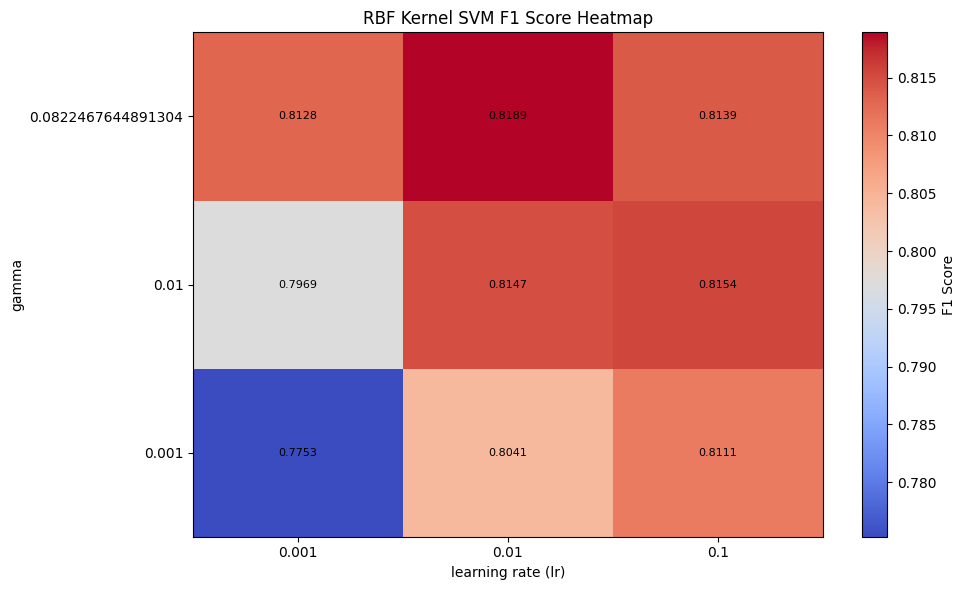

In [241]:
def plot_ksvm_results(results, lr_values, gamma_values):
    f1_matrix = np.array([
        [ksvm_tuning_results.get((lr, g), np.nan) for lr in lr_values]
        for g in gamma_values
    ])

    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(f1_matrix, cmap="coolwarm", aspect='auto', origin='lower')

    ax.set_xticks(np.arange(len(lr_values)))
    ax.set_yticks(np.arange(len(gamma_values)))
    ax.set_xticklabels([str(lr) for lr in lr_values], rotation=0)
    ax.set_yticklabels([str(g) for g in gamma_values])

    ax.set_xlabel("learning rate (lr)")
    ax.set_ylabel("gamma")
    ax.set_title("RBF Kernel SVM F1 Score Heatmap")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("F1 Score")

    for i in range(len(gamma_values)):
        for j in range(len(lr_values)):
            val = f1_matrix[i, j]
            if not np.isnan(val):
                ax.text(j, i, f"{val:.4f}", ha="center", va="center", color="black", fontsize=8)

    plt.tight_layout()
    plt.show()

results = ksvm_grid.cv_results_

ksvm_tuning_results = {
    (p['learning_rate'], p['gamma']): f1
    for p, f1 in zip(results['params'], results['mean_test_score'])
}

ksvm_lr_values = sorted(set(p['learning_rate'] for p in results['params']))
ksvm_gamma_values = sorted(set(p['gamma'] for p in results['params']))

plot_ksvm_results(ksvm_tuning_results, ksvm_lr_values, ksvm_gamma_values)

In [242]:
print(best_ksvm_params)

{'C': 100, 'gamma': np.float64(0.0822467644891304), 'kernel': 'rbf', 'learning_rate': 0.01, 'n_iter': 100}


### Training, evaluation and comparison (RBF Kernels)

KLR training and evaluation using 3-Fold-CV (warning: runtime may take ~20min) \\

In [263]:
summary_klr = train_eval_cv(KernelLogisticRegression, X, y, best_klr_params, k=3, model_name="KLR")

 33%|███▎      | 1/3 [05:28<10:57, 328.52s/it]

Fold 1: Train Acc = 0.7148 | Val Acc = 0.7188 | Time = 120.79s


 67%|██████▋   | 2/3 [10:54<05:26, 326.78s/it]

Fold 2: Train Acc = 0.7229 | Val Acc = 0.7050 | Time = 119.69s


100%|██████████| 3/3 [16:16<00:00, 325.47s/it]

Fold 3: Train Acc = 0.7154 | Val Acc = 0.7238 | Time = 116.95s


KSVM training and evaluation using 3-Fold-CV \\

In [243]:
summary_ksvm = train_eval_cv(KernelSVM, X, y, best_ksvm_params, k=3, model_name="KSVM")

 33%|███▎      | 1/3 [01:12<02:24, 72.12s/it]

Fold 1: Train Acc = 0.7989 | Val Acc = 0.7756 | Time = 71.37s


 67%|██████▋   | 2/3 [02:26<01:13, 73.68s/it]

Fold 2: Train Acc = 0.8063 | Val Acc = 0.7585 | Time = 74.02s


100%|██████████| 3/3 [03:40<00:00, 73.60s/it]

Fold 3: Train Acc = 0.7948 | Val Acc = 0.7732 | Time = 73.15s


#### Training Curves

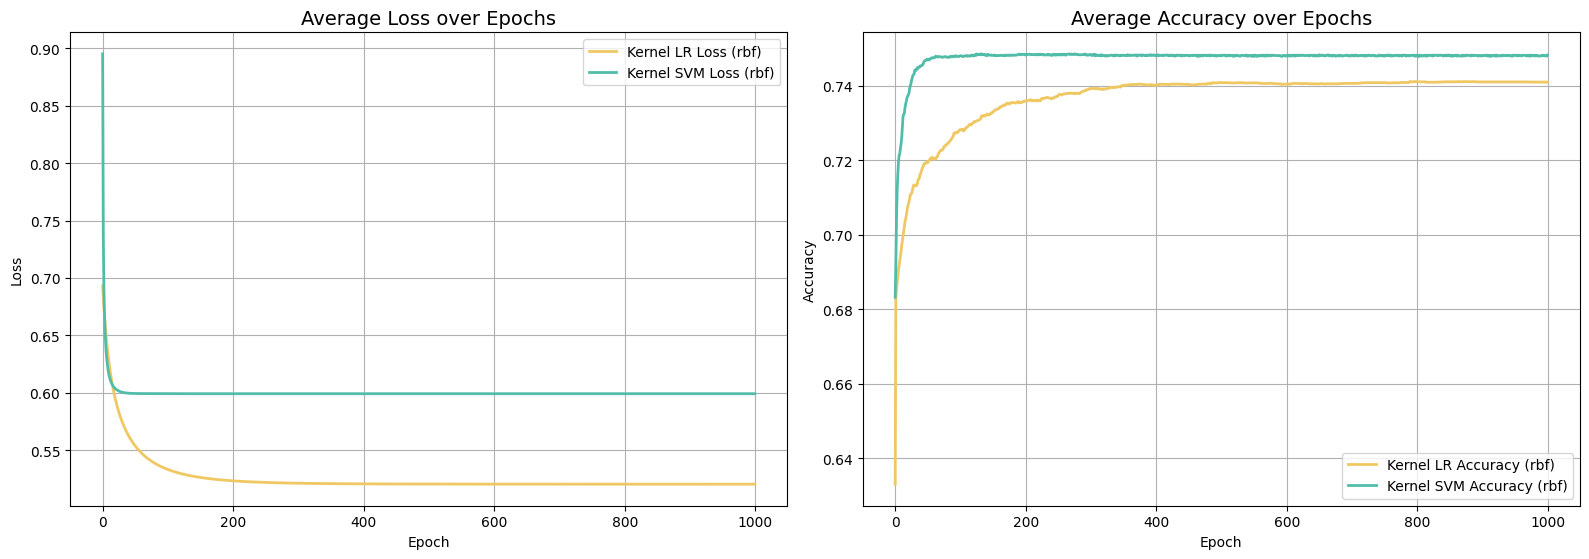

In [283]:
def plot_compare_training_curves_k(loss_ksvm, acc_ksvm, loss_klr, acc_klr, kernel_svm='rbf', kernel_lr='rbf'):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(loss_klr, label=f"Kernel LR Loss ({kernel_lr})", color='#f0c862', linewidth=2)
    axs[0].plot(loss_ksvm, label=f"Kernel SVM Loss ({kernel_svm})", color='#51bda9', linewidth=2)
    axs[0].set_title("Average Loss over Epochs", fontsize=14)
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(acc_klr, label=f"Kernel LR Accuracy ({kernel_lr})", color='#f0c862', linewidth=2)
    axs[1].plot(acc_ksvm, label=f"Kernel SVM Accuracy ({kernel_svm})", color='#51bda9', linewidth=2)
    axs[1].set_title("Average Accuracy over Epochs", fontsize=14)
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_compare_training_curves_k(
    summary_svm['avg_train_loss_curve'], summary_svm['avg_train_acc_curve'],
    summary_lr['avg_train_loss_curve'], summary_lr['avg_train_acc_curve'],
    kernel_svm='rbf', kernel_lr='rbf'
)

In [268]:
analyze_train_curves(summary_klr, "RBF Kernel Logistic Regression")
analyze_train_curves(summary_ksvm, "RBF Kernel SVM")


RBF Kernel Logistic Regression per-epoch training curve summary (averaged over folds)

 Train loss:
  • first epoch: 0.6932
  • final epoch: 0.5501
  • min loss: 0.5501
  • total drop: 20.64%
  • final 5-epoch change: 0.0012
  • trend: stable

 Train accuracy:
  • first epoch: 0.6331
  • final epoch: 0.7172
  • total gain: +13.29%
  • final 5-epoch change: 0.0004
  • trend: stable

RBF Kernel SVM per-epoch training curve summary (averaged over folds)

 Train loss:
  • first epoch: 0.7274
  • final epoch: 2.4056
  • min loss: 0.6977
  • total drop: -230.70%
  • final 5-epoch change: 0.0790
  • trend: still changing

 Train accuracy:
  • first epoch: 0.6364
  • final epoch: 0.8000
  • total gain: +25.71%
  • final 5-epoch change: 0.0002
  • trend: stable


#### Classification metrics comparison

Average Precision, Recall, F1, Val accuracy comparison

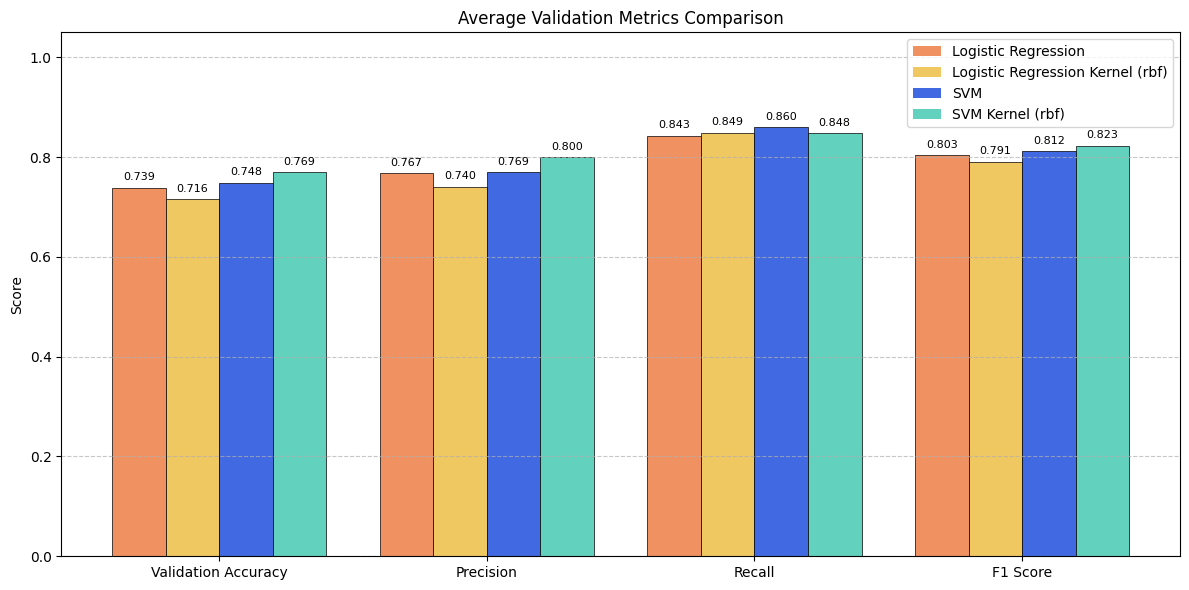

In [270]:
def plot_all_metric_histograms(summary_lr, summary_svm, summary_klr, summary_ksvm):
    metrics_names = ['val_accuracy', 'precision', 'recall', 'f1']
    labels = ['Validation Accuracy', 'Precision', 'Recall', 'F1 Score']

    def get_means(summary):
        return [np.mean(summary[m]) for m in metrics_names]

    models = {
        "Logistic Regression": get_means(summary_lr),
        "Logistic Regression Kernel (rbf)": get_means(summary_klr),
        "SVM": get_means(summary_svm),
        "SVM Kernel (rbf)": get_means(summary_ksvm)
    }

    x = np.arange(len(metrics_names))
    total_width = 0.8
    n_models = len(models)
    width = total_width / n_models

    colors = ['#f09162', '#f0c862', '#4169e1', '#62d1bd']

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (model_name, means) in enumerate(models.items()):
        offset = (i - n_models / 2) * width + width / 2
        rects = ax.bar(x + offset, means, width, label=model_name, color=colors[i])
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    ax.set_ylabel('Score')
    ax.set_title('Average Validation Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in ax.patches:
        bar.set_edgecolor('black')
        bar.set_linewidth(0.5)

    plt.tight_layout()
    plt.show()

plot_all_metric_histograms(summary_lr, summary_svm, summary_klr, summary_ksvm)

#### Confusion matrices + misclassifications

Average confusion matrices

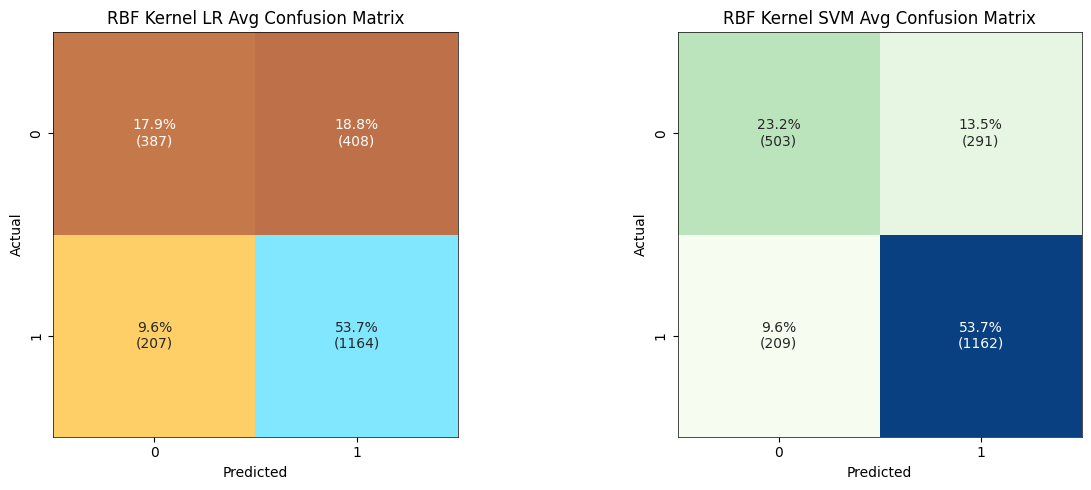

In [271]:
def plot_avg_conf_matrices_k(avg_cm_lr, avg_cm_svm):

    int_cm_lr = np.rint(avg_cm_lr).astype(int)
    int_cm_svm = np.rint(avg_cm_svm).astype(int)

    percent_cm_lr = avg_cm_lr / np.sum(avg_cm_lr) * 100
    percent_cm_svm = avg_cm_svm / np.sum(avg_cm_svm) * 100

    def make_labels(percent_cm, int_cm):
        labels = []
        for i in range(percent_cm.shape[0]):
            row = []
            for j in range(percent_cm.shape[1]):
                perc = f"{percent_cm[i, j]:.1f}%"
                count = f"({int(int_cm[i, j])})"
                row.append(f"{perc}\n{count}")
            labels.append(row)
        return np.array(labels)

    labels_lr = make_labels(percent_cm_lr, int_cm_lr)
    labels_svm = make_labels(percent_cm_svm, int_cm_svm)

    fig, axs = plt.subplots(1, 2, figsize=(13, 5))

    sns.heatmap(percent_cm_lr, annot=labels_lr, fmt='', cmap='managua', ax=axs[0], cbar=False, square=True)
    axs[0].set_title("RBF Kernel LR Avg Confusion Matrix", fontsize=12)

    sns.heatmap(percent_cm_svm, annot=labels_svm, fmt='', cmap='GnBu', ax=axs[1], cbar=False, square=True)
    axs[1].set_title("RBF Kernel SVM Avg Confusion Matrix", fontsize=12)

    for ax in axs:
        ax.set_xlabel("Predicted", fontsize=10)
        ax.set_ylabel("Actual", fontsize=10)

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_color('black')

    plt.tight_layout()
    plt.show()

avg_cm_klr = np.mean(summary_klr['confusions'], axis=0)
avg_cm_ksvm = np.mean(summary_ksvm['confusions'], axis=0)
plot_avg_conf_matrices_k(avg_cm_klr, avg_cm_ksvm)

Average classification report

In [282]:
avg_classification_report(summary_klr['classification_reports'], model_name="RBF Kernel Logistic Regression")
avg_classification_report(summary_ksvm['classification_reports'], model_name="RBF Kernel SVM")


RBF Kernel Logistic Regression - Average Classification Report:

              precision  recall  f1-score   support
0                 0.652   0.486     0.557   794.667
1                 0.740   0.849     0.791  1371.000
accuracy          0.716   0.716     0.716     0.716
macro avg         0.696   0.668     0.674  2165.667
weighted avg      0.708   0.716     0.705  2165.667

RBF Kernel SVM - Average Classification Report:

              precision  recall  f1-score   support
0                 0.707   0.634     0.668   794.667
1                 0.800   0.848     0.823  1371.000
accuracy          0.769   0.769     0.769     0.769
macro avg         0.753   0.741     0.746  2165.667
weighted avg      0.766   0.769     0.766  2165.667


Feature mean differences

In [272]:
lr_feat_diff_df = get_feature_mean_differences(summary_klr, feature_names, "RBF Kernel Logistic Regression")
svm_feat_diff_df = get_feature_mean_differences(summary_ksvm, feature_names, "RBF Kernel SVM")


RBF Kernel Logistic Regression - Feature Mean Differences:

                 Feature  Misclassified Mean  Correct Mean      Diff
10               alcohol           -0.398806      0.158287 -0.557093
7                density            0.303906     -0.120622  0.424528
3         residual sugar            0.151805     -0.060252  0.212057
4              chlorides            0.118801     -0.047152  0.165953
6   total sulfur dioxide            0.115306     -0.045765  0.161071
8                     pH           -0.076898      0.030521 -0.107419
0          fixed acidity            0.056474     -0.022415  0.078888
9              sulphates           -0.041545      0.016489 -0.058034
1       volatile acidity            0.035248     -0.013990  0.049237
2            citric acid           -0.024184      0.009599 -0.033782
11                  type           -0.015939      0.006326 -0.022266
5    free sulfur dioxide            0.013575     -0.005388  0.018963

RBF Kernel SVM - Feature Mean Differences

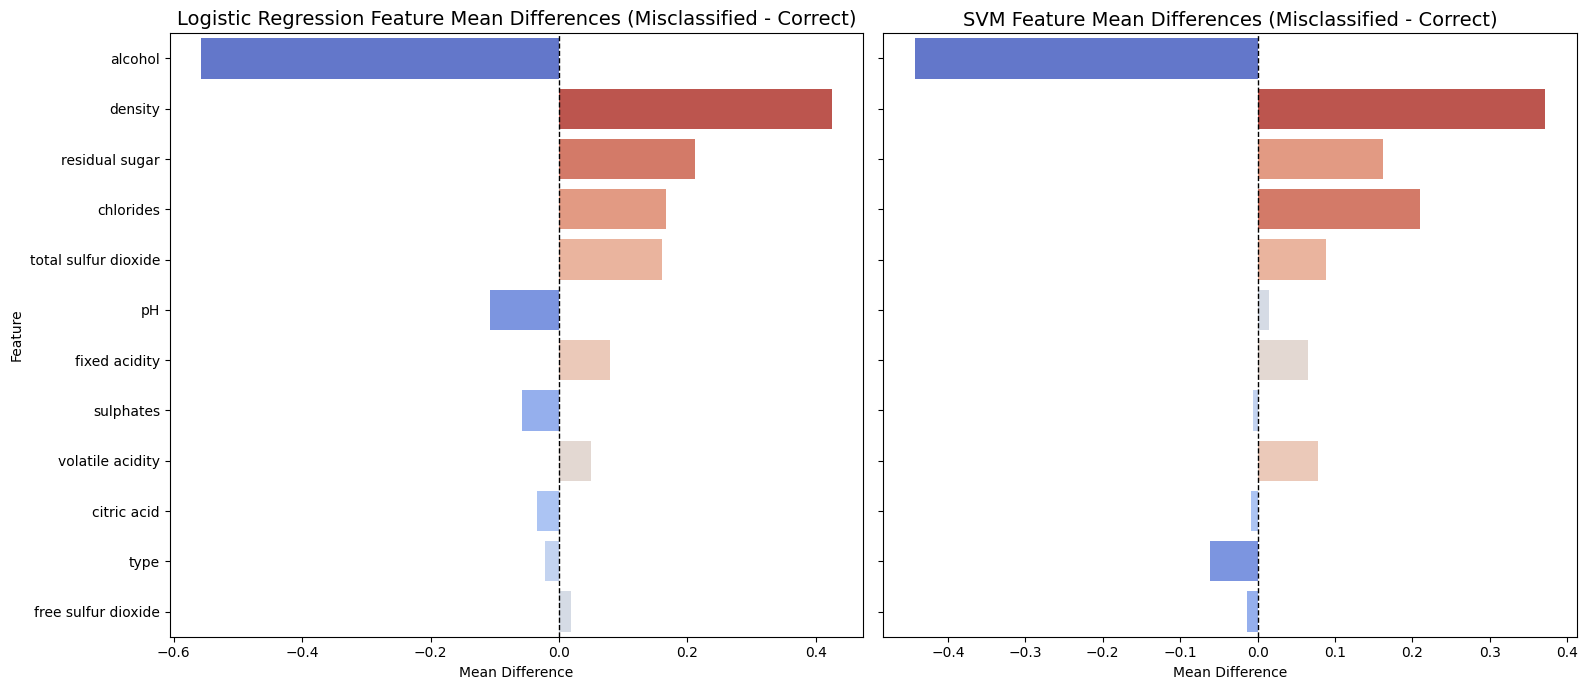

In [273]:
plot_feature_mean_differences_side_by_side(lr_feat_diff_df, svm_feat_diff_df, "Logistic Regression", "SVM")

#### Overfitting gaps

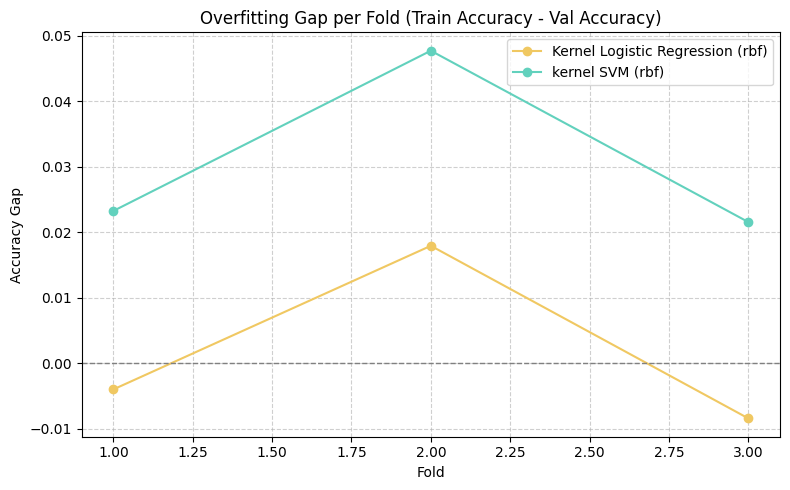

In [276]:
def plot_overfitting_gaps_comparison_k(metrics_lr, metrics_svm):
    gap_lr = np.array(metrics_lr['train_accuracy']) - np.array(metrics_lr['val_accuracy'])
    gap_svm = np.array(metrics_svm['train_accuracy']) - np.array(metrics_svm['val_accuracy'])

    folds = np.arange(1, len(gap_lr) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(folds, gap_lr, marker='o', label='Kernel Logistic Regression (rbf)', color='#f0c862')
    plt.plot(folds, gap_svm, marker='o', label='kernel SVM (rbf)', color='#62d1bd')

    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title("Overfitting Gap per Fold (Train Accuracy - Val Accuracy)")
    plt.xlabel("Fold")
    plt.ylabel("Accuracy Gap")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_overfitting_gaps_comparison_k(summary_klr, summary_ksvm)

Overfitting analysis

In [277]:
analyse_overfitting(summary_klr, model_name="RBF Kernel Logistic Regression")
analyse_overfitting(summary_ksvm, model_name="RBF Kernel SVM")


RBF Kernel Logistic Regression Overfitting Analysis:
  Min Overfitting Gap: -0.0084
  Max Overfitting Gap: 0.0179
  Mean Overfitting Gap: 0.0018
  Std Dev Overfitting Gap: 0.0115
  Bias Estimate: 0.0018
  Variance Estimate: 0.0080
  Mean Accuracy Gap: 0.0018
  Variance of Accuracy Gap: 0.0001

RBF Kernel SVM Overfitting Analysis:
  Min Overfitting Gap: 0.0216
  Max Overfitting Gap: 0.0477
  Mean Overfitting Gap: 0.0309
  Std Dev Overfitting Gap: 0.0120
  Bias Estimate: 0.0309
  Variance Estimate: 0.0075
  Mean Accuracy Gap: 0.0309
  Variance of Accuracy Gap: 0.0001


#### Other metrics

In [278]:
print_advanced_cv_metrics(summary_ksvm, model_name="Kernel SVM")


 Kernel SVM Cross-Validation Metrics + Advanced Stats 

Fold 1:
  Train Loss: 2.3608
  Val Loss: nan
  Train Accuracy: 0.7989
  Val Accuracy: 0.7756
  Precision: 0.8116
  Recall: 0.8423
  F1 Score: 0.8267
  Accuracy Gap (Train - Val): 0.0233
  Confusion Matrix:
[[ 521  269]
 [ 217 1159]]

Fold 2:
  Train Loss: 2.4668
  Val Loss: nan
  Train Accuracy: 0.8063
  Val Accuracy: 0.7585
  Precision: 0.7828
  Recall: 0.8503
  F1 Score: 0.8151
  Accuracy Gap (Train - Val): 0.0477
  Confusion Matrix:
[[ 490  320]
 [ 203 1153]]

Fold 3:
  Train Loss: 2.3893
  Val Loss: nan
  Train Accuracy: 0.7948
  Val Accuracy: 0.7732
  Precision: 0.8048
  Recall: 0.8508
  F1 Score: 0.8272
  Accuracy Gap (Train - Val): 0.0216
  Confusion Matrix:
[[ 499  285]
 [ 206 1175]]

  Average Metrics Across 3 Folds
  Train Loss: 2.4056 ± 0.0448
  Val Loss: nan ± nan
  Train Accuracy: 0.8000 ± 0.0048
  Val Accuracy: 0.7691 ± 0.0075
  Precision: 0.7997 ± 0.0123
  Recall: 0.8478 ± 0.0039
  F1 Score: 0.8230 ± 0.0056
  Accur

In [279]:
print_advanced_cv_metrics(summary_klr, model_name="Kernel Logistic Regression")


 Kernel Logistic Regression Cross-Validation Metrics + Advanced Stats 

Fold 1:
  Train Loss: 0.5508
  Val Loss: 0.5477
  Train Accuracy: 0.7148
  Val Accuracy: 0.7188
  Precision: 0.7348
  Recall: 0.8721
  F1 Score: 0.7976
  Accuracy Gap (Train - Val): -0.0040
  Confusion Matrix:
[[ 357  433]
 [ 176 1200]]

Fold 2:
  Train Loss: 0.5434
  Val Loss: 0.5655
  Train Accuracy: 0.7229
  Val Accuracy: 0.7050
  Precision: 0.7354
  Recall: 0.8260
  F1 Score: 0.7780
  Accuracy Gap (Train - Val): 0.0179
  Confusion Matrix:
[[ 407  403]
 [ 236 1120]]

Fold 3:
  Train Loss: 0.5561
  Val Loss: 0.5390
  Train Accuracy: 0.7154
  Val Accuracy: 0.7238
  Precision: 0.7511
  Recall: 0.8479
  F1 Score: 0.7966
  Accuracy Gap (Train - Val): -0.0084
  Confusion Matrix:
[[ 396  388]
 [ 210 1171]]

  Average Metrics Across 3 Folds
  Train Loss: 0.5501 ± 0.0052
  Val Loss: 0.5507 ± 0.0111
  Train Accuracy: 0.7177 ± 0.0037
  Val Accuracy: 0.7159 ± 0.0080
  Precision: 0.7405 ± 0.0075
  Recall: 0.8487 ± 0.0188
  